/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(



=== Iteration 1 ===
Iter 1/150 - Loss: 379.0359
Iter 11/150 - Loss: 377.0884
Iter 21/150 - Loss: 377.3218
Iter 31/150 - Loss: 377.3090
Iter 41/150 - Loss: 377.0288
Iter 51/150 - Loss: 376.9608
Iter 61/150 - Loss: 377.2325
Iter 71/150 - Loss: 377.2656
Iter 81/150 - Loss: 377.3285
Iter 91/150 - Loss: 377.1701
Iter 101/150 - Loss: 377.3993
Iter 111/150 - Loss: 377.2251
Iter 121/150 - Loss: 377.1122
Iter 131/150 - Loss: 377.4798
Iter 141/150 - Loss: 377.0798
Iter 150/150 - Loss: 377.1596
Iter 1/150 - Loss: 4.9192
Iter 11/150 - Loss: 3.2275
Iter 21/150 - Loss: 2.6990
Iter 31/150 - Loss: 2.5027
Iter 41/150 - Loss: 2.4090
Iter 51/150 - Loss: 2.3635
Iter 61/150 - Loss: 2.3417
Iter 71/150 - Loss: 2.3307


/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Iter 81/150 - Loss: 2.3226
Iter 91/150 - Loss: 2.3154
Iter 101/150 - Loss: 2.3095
Iter 111/150 - Loss: 2.3041
Iter 121/150 - Loss: 2.2944
Iter 131/150 - Loss: 2.2749
Iter 141/150 - Loss: 2.2685
Iter 150/150 - Loss: 2.2648

=== Iteration 2 ===
Iter 1/150 - Loss: 1.2451
Iter 11/150 - Loss: 1.2322
Iter 21/150 - Loss: 1.2315
Iter 31/150 - Loss: 1.2310
Iter 41/150 - Loss: 1.2309
Iter 51/150 - Loss: 1.2308
Iter 61/150 - Loss: 1.2308
Iter 71/150 - Loss: 1.2308
Iter 81/150 - Loss: 1.2308
Iter 91/150 - Loss: 1.2308
Iter 101/150 - Loss: 1.2308
Iter 111/150 - Loss: 1.2308
Iter 121/150 - Loss: 1.2308
Iter 131/150 - Loss: 1.2308
Iter 141/150 - Loss: 1.2308
Iter 150/150 - Loss: 1.2308
Iter 1/150 - Loss: 2.2426
Iter 11/150 - Loss: 2.2325
Iter 21/150 - Loss: 2.2323
Iter 31/150 - Loss: 2.2318
Iter 41/150 - Loss: 2.2318
Iter 51/150 - Loss: 2.2317
Iter 61/150 - Loss: 2.2317
Iter 71/150 - Loss: 2.2317
Iter 81/150 - Loss: 2.2317
Iter 91/150 - Loss: 2.2317
Iter 101/150 - Loss: 2.2317
Iter 111/150 - Loss: 2.

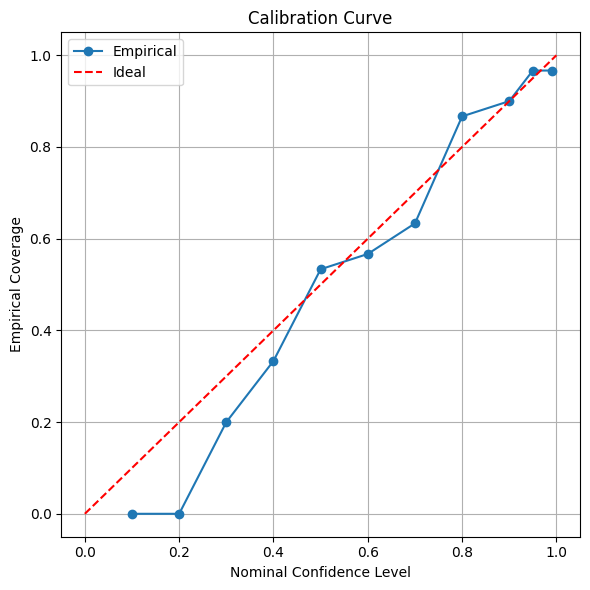

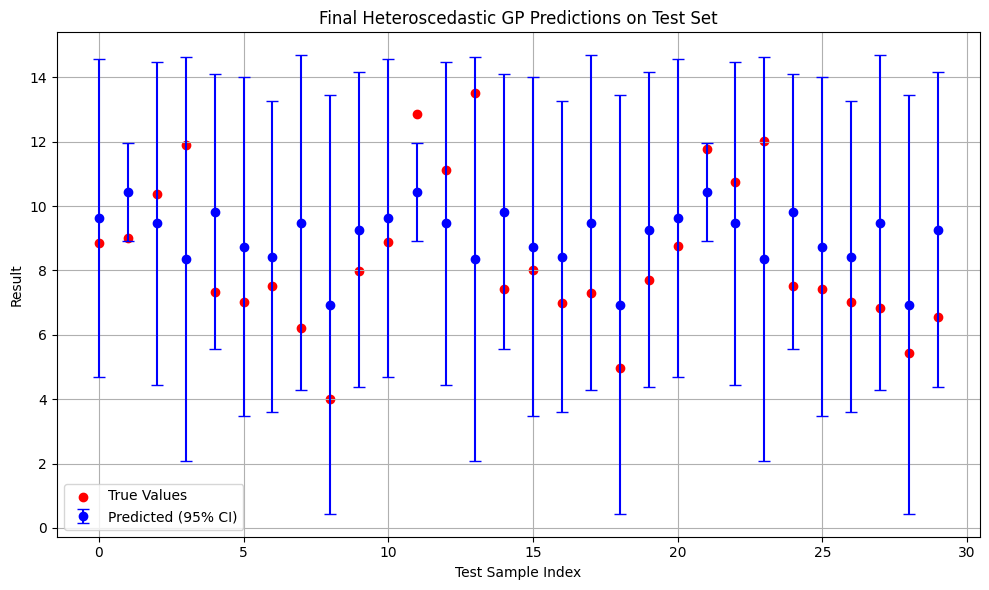

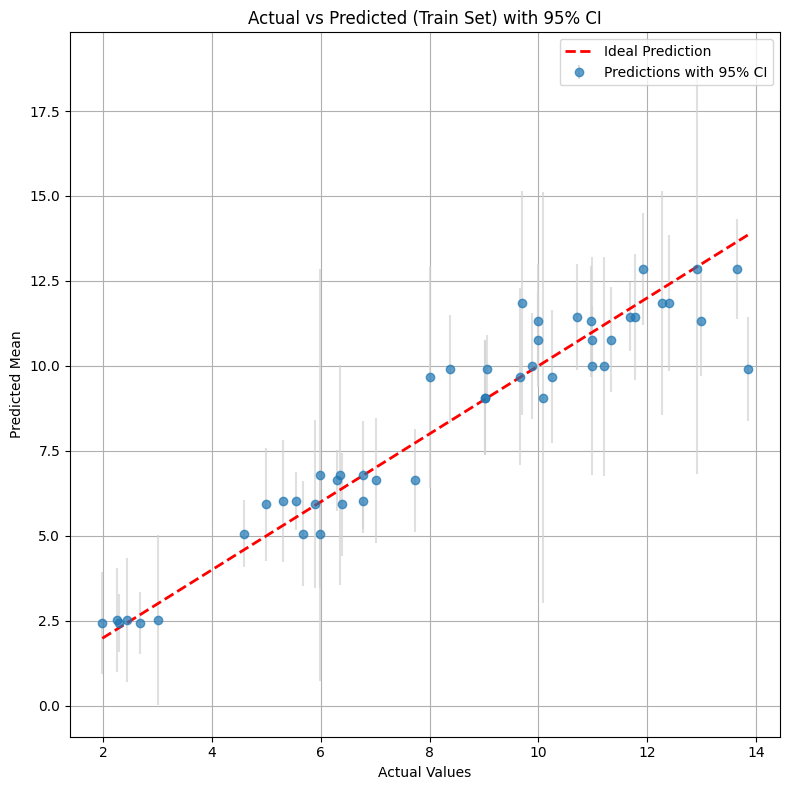

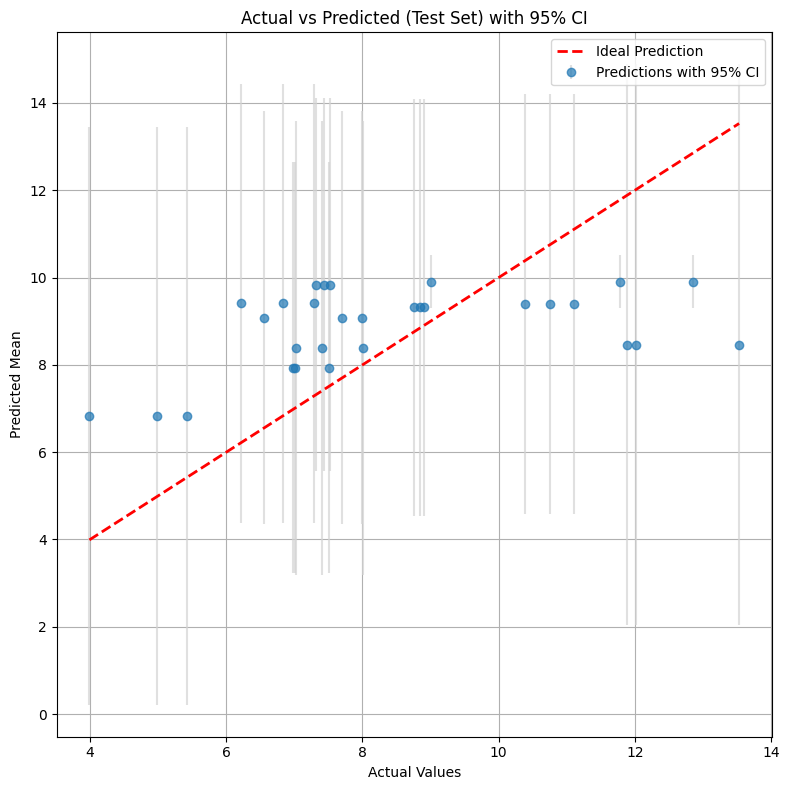

In [21]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.stats

# === Load and preprocess data ===
df = pd.read_excel('data.xlsx')
relevant_columns = ['a', 'b', 'c', 'd']

df_train, df_test = train_test_split(df, test_size=0.35, random_state=42)
train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_raw)
X_test = x_scaler.transform(X_test_raw)

y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

# === GP model definitions ===
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        input_dim = train_x.shape[1]
        kernel = gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=input_dim)
        kernel.register_constraint("raw_lengthscale", gpytorch.constraints.Interval(1e-2, 10.0))
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# === GP training function ===
def train_gp(model, likelihood, train_x, train_y, training_iter=100, lr=0.1):
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        if i % 10 == 0 or i == training_iter - 1:
            print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.4f}")

# === Initialize likelihoods and models ===
fixed_noise_floor = 1e-6  # tiny noise to avoid numerical instability
mean_likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.full_like(train_y, fixed_noise_floor))
noise_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6))

mean_model = GPModel(train_x, train_y, mean_likelihood)
noise_model = GPModel(train_x, torch.zeros_like(train_y), noise_likelihood)

# === Iterative training: mean GP ↔ noise GP ===
n_iterations = 5
for iteration in range(n_iterations):
    print(f"\n=== Iteration {iteration+1} ===")

    # Train mean GP
    train_gp(mean_model, mean_likelihood, train_x, train_y, training_iter=150)

    # Get residuals
    mean_model.eval()
    mean_likelihood.eval()
    with torch.no_grad():
        f_mean = mean_model(train_x).mean
    residuals = (train_y - f_mean) ** 2
    log_residuals = torch.log(residuals + 1e-6)  # avoid log(0)

    # Train noise GP on log-residuals
    noise_model.set_train_data(inputs=train_x, targets=log_residuals, strict=False)
    train_gp(noise_model, noise_likelihood, train_x, log_residuals, training_iter=150)

    # Predict per-point noise from noise GP
    noise_model.eval()
    with torch.no_grad():
        log_noise_pred = noise_model(train_x).mean
        noise_var_pred = torch.exp(log_noise_pred).clamp(min=1e-4)

    # Update mean GP's fixed noise
    mean_likelihood.noise = noise_var_pred

# === Final prediction ===
mean_model.eval()
mean_likelihood.eval()
noise_model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = mean_model(test_x)
    mean_pred = pred_dist.mean.numpy()
    gp_var = pred_dist.variance.numpy()

    log_noise_pred_test = noise_model(test_x).mean.numpy()
    noise_var_pred_test = np.exp(log_noise_pred_test)
    total_var = gp_var + noise_var_pred_test
    total_std = np.sqrt(total_var)

# === Unscale ===
mean_pred_unscaled = y_scaler.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
total_std_unscaled = total_std * y_scaler.scale_[0]

# === Evaluation ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_raw, mean_pred_unscaled)
mse = mean_squared_error(y_test_raw, mean_pred_unscaled)
r2 = r2_score(y_test_raw, mean_pred_unscaled)

print("\n=== Final Heteroscedastic GP Test Evaluation ===")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# === Calibration Plot ===
def compute_and_plot_coverage(y_true, y_pred, std_pred, levels=None):
    if levels is None:
        levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
    coverages = {}
    for level in levels:
        z = scipy.stats.norm.ppf(0.5 + level/2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred
        coverage = np.mean((y_true >= lower) & (y_true <= upper))
        coverages[round(level,4)] = coverage
        print(f"{int(level*100)}% CI → Empirical coverage: {coverage*100:.2f}%")
    plt.figure(figsize=(6, 6))
    plt.plot(list(coverages.keys()), list(coverages.values()), marker='o', label='Empirical')
    plt.plot([0,1],[0,1],'r--', label='Ideal')
    plt.xlabel("Nominal Confidence Level")
    plt.ylabel("Empirical Coverage")
    plt.title("Calibration Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nTest set calibration:")
compute_and_plot_coverage(y_test_raw, mean_pred_unscaled, total_std_unscaled)

# === Final predictions plot ===
plt.figure(figsize=(10,6))
indices = np.arange(len(y_test_raw))
plt.errorbar(indices, mean_pred_unscaled,
             yerr=1.96 * total_std_unscaled,
             fmt='o', color='blue', capsize=4, label='Predicted (95% CI)')
plt.scatter(indices, y_test_raw, color='red', label='True Values')
plt.title('Final Heteroscedastic GP Predictions on Test Set')
plt.xlabel('Test Sample Index')
plt.ylabel('Result')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def plot_actual_vs_predicted(y_true, y_pred, lower, upper, title):
    plt.figure(figsize=(8, 8))
    plt.errorbar(y_true, y_pred,
                 yerr=[y_pred - lower, upper - y_pred],
                 fmt='o', ecolor='lightgray', alpha=0.7, label='Predictions with 95% CI')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Mean')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Actual vs Predicted plots with intervals
plot_actual_vs_predicted(y_train_unscaled, train_mean_unscaled, train_lower_unscaled, train_upper_unscaled,
                        'Actual vs Predicted (Train Set) with 95% CI')

plot_actual_vs_predicted(y_test_raw, test_mean_unscaled, lower_unscaled, upper_unscaled,
                        'Actual vs Predicted (Test Set) with 95% CI')



In [16]:
noise_var_pred

tensor([0.0357, 0.0185, 0.0083, 0.0171, 0.0340, 0.0394, 0.0419, 0.0313, 0.0050,
        0.0043, 0.0348, 0.0171, 0.0187, 0.0186, 0.0078, 0.0349, 0.0357, 0.0185,
        0.0083, 0.0171, 0.0340, 0.0394, 0.0419, 0.0313, 0.0050, 0.0043, 0.0348,
        0.0171, 0.0187, 0.0186, 0.0078, 0.0349, 0.0357, 0.0185, 0.0083, 0.0171,
        0.0340, 0.0394, 0.0419, 0.0313, 0.0050, 0.0043, 0.0348, 0.0171, 0.0187,
        0.0186, 0.0078, 0.0349])

Iter 1/200 - Loss: 2.084
Iter 11/200 - Loss: 1.211
Iter 21/200 - Loss: 1.156
Iter 31/200 - Loss: 1.152
Iter 41/200 - Loss: 1.149
Iter 51/200 - Loss: 1.146
Iter 61/200 - Loss: 1.143
Iter 71/200 - Loss: 1.141
Iter 81/200 - Loss: 1.140
Iter 91/200 - Loss: 1.139
Iter 101/200 - Loss: 1.139
Iter 111/200 - Loss: 1.138
Iter 121/200 - Loss: 1.137
Iter 131/200 - Loss: 1.137
Iter 141/200 - Loss: 1.137
Iter 151/200 - Loss: 1.136
Iter 161/200 - Loss: 1.136
Iter 171/200 - Loss: 1.136
Iter 181/200 - Loss: 1.136
Iter 191/200 - Loss: 1.136
Iter 200/200 - Loss: 1.136

=== GPR Train Set Evaluation ===

=== Train Set Evaluation ===
MAE: 0.6931
MSE: 0.9369
R²: 0.9147
Calibration Error: 0.0286
MSCE: 0.0011
Sharpness (90% CI): 3.4278
NLL: -0.6480

=== GPR Test Set Evaluation ===

=== Test Set Evaluation ===
MAE: 1.8170
MSE: 4.5376
R²: 0.1680
Calibration Error: 0.0491
MSCE: 0.0038
Sharpness (90% CI): 7.9155
NLL: 2.1036

Train Calibration Curve:
10% CI → Empirical coverage: 14.58%
20% CI → Empirical coverage: 

/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


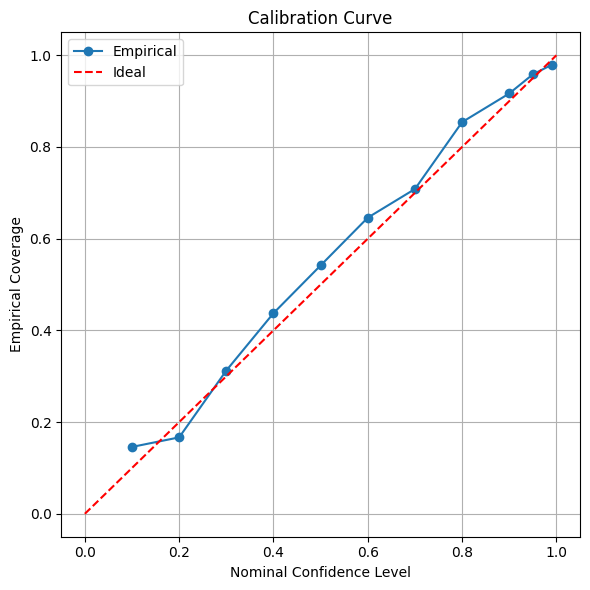


Test Calibration Curve:
10% CI → Empirical coverage: 0.00%
20% CI → Empirical coverage: 16.67%
30% CI → Empirical coverage: 20.00%
40% CI → Empirical coverage: 40.00%
50% CI → Empirical coverage: 50.00%
60% CI → Empirical coverage: 56.67%
70% CI → Empirical coverage: 63.33%
80% CI → Empirical coverage: 86.67%
90% CI → Empirical coverage: 90.00%
95% CI → Empirical coverage: 90.00%
99% CI → Empirical coverage: 90.00%


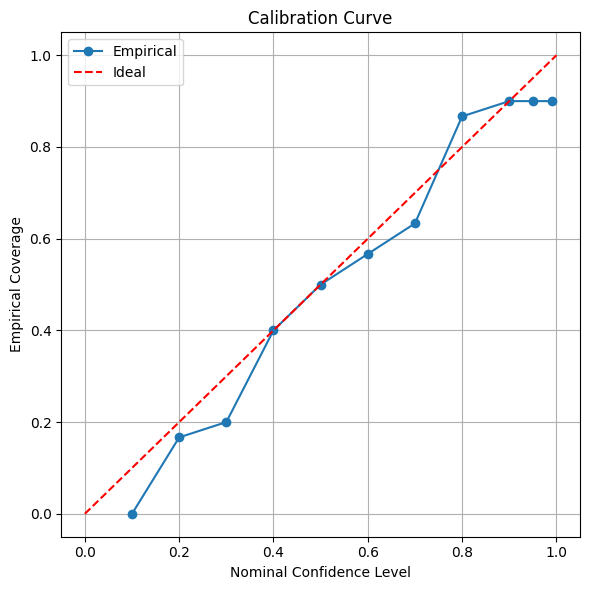

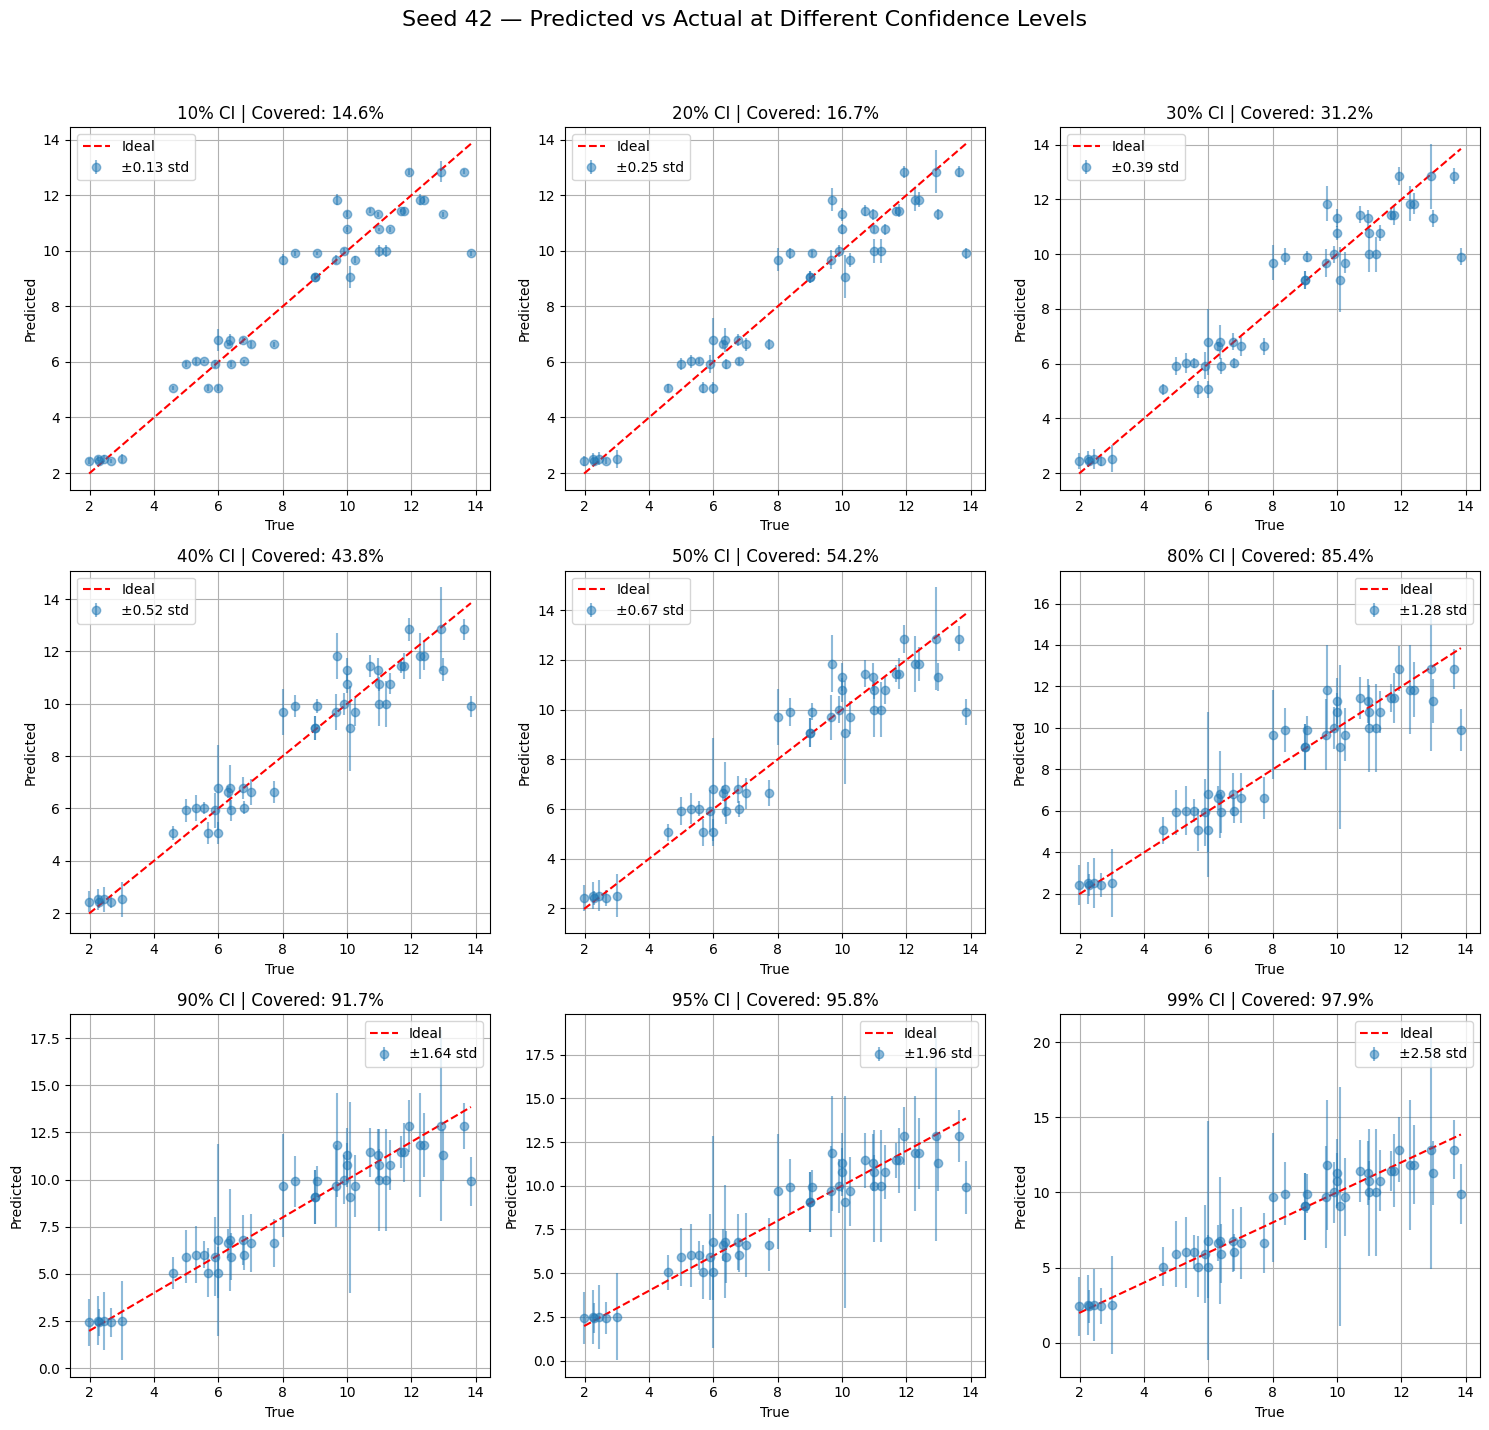

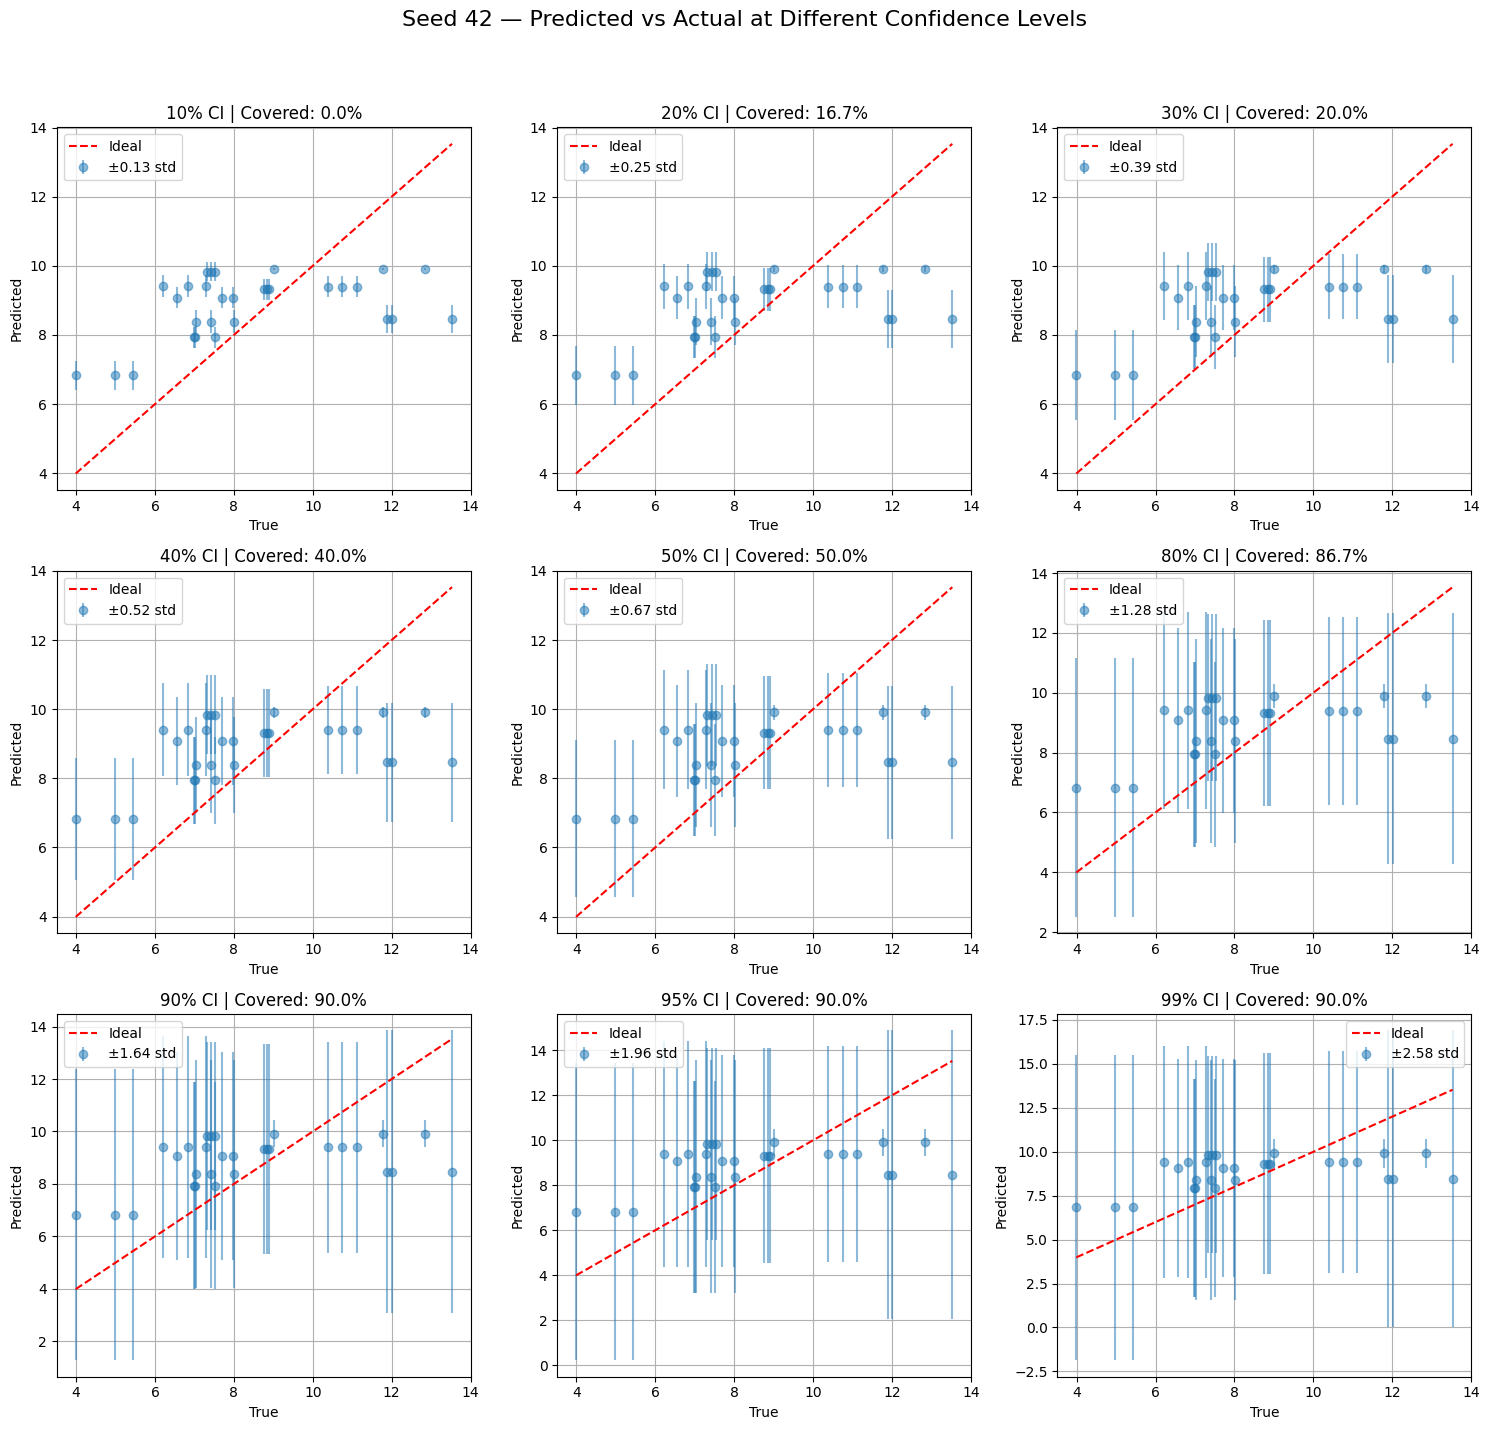

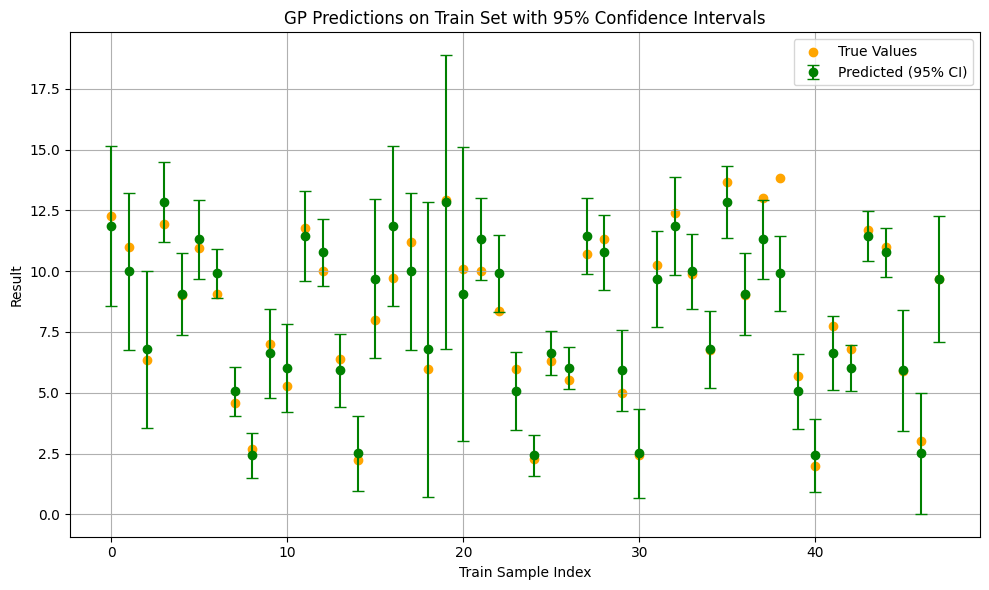

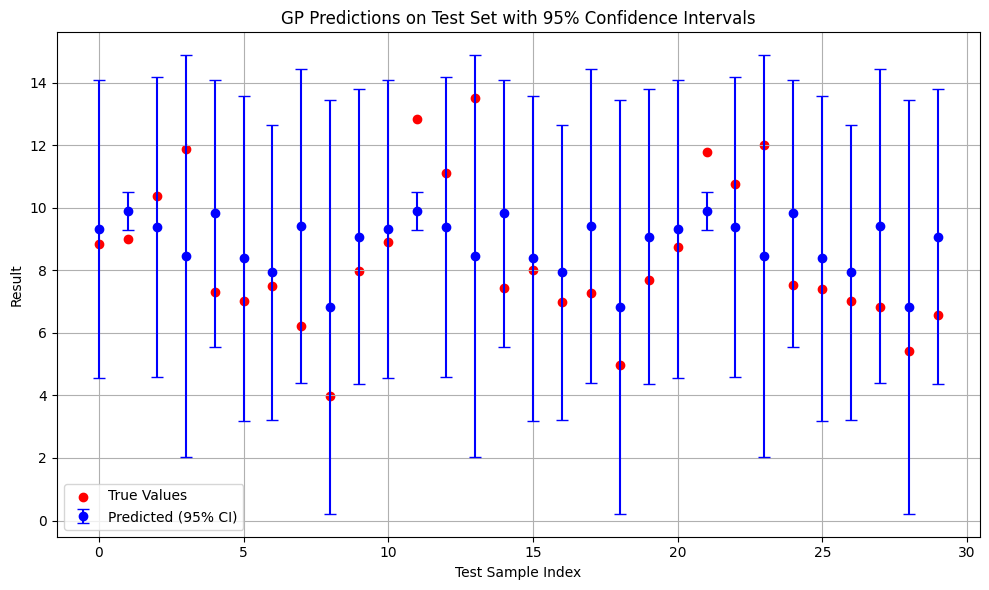

Predictions saved to 'gp_test_predictions.csv'

=== Final Learned Parameters ===
Mean: -0.537918
Kernel Outputscale: 1.049719
Kernel Lengthscale: [1.2441437 1.2152622 1.5361462 1.8995593]
Used FixedNoiseGaussianLikelihood with per-sample heteroscedastic noise.


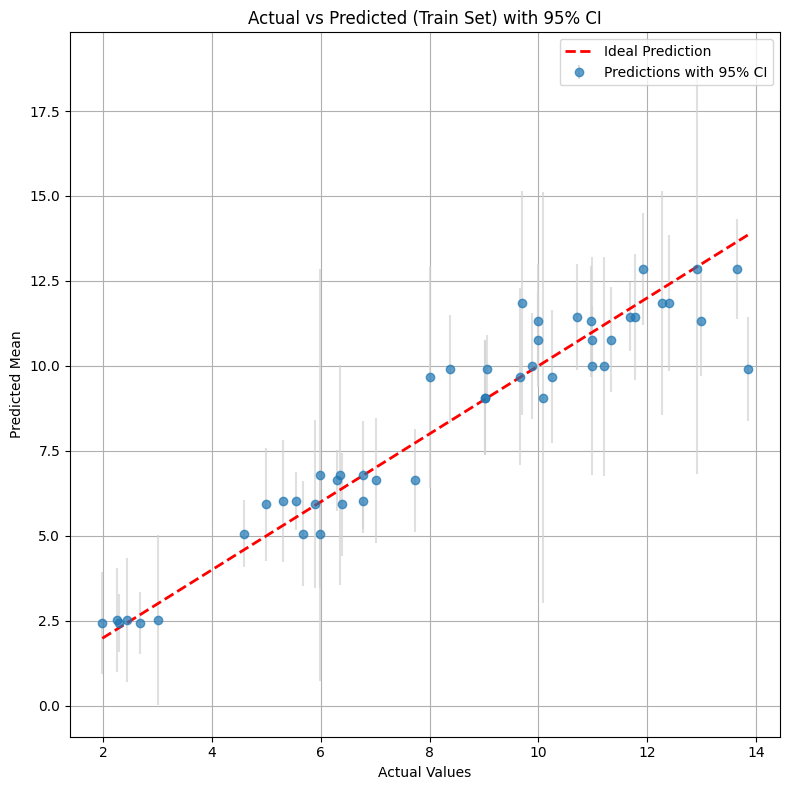

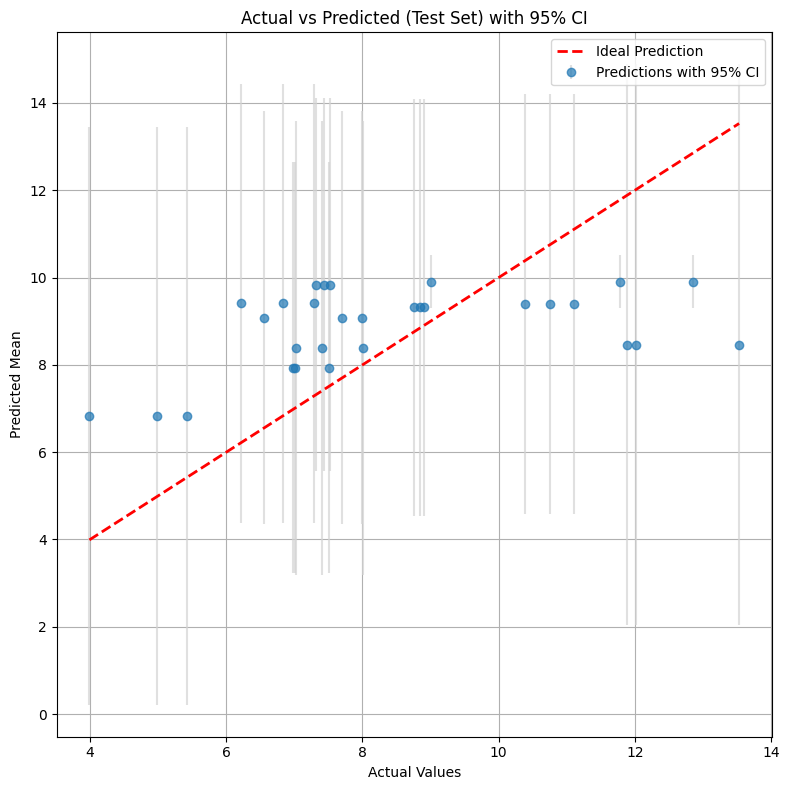

In [1]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats
import math

# === Load data ===
df = pd.read_excel('data.xlsx')  # expects columns: a, b, c, d, 1, 2, 3
relevant_columns = ['a', 'b', 'c', 'd']

# === Split BEFORE melting ===
df_train, df_test = train_test_split(df, test_size=0.35, random_state=42)

# === Melt to long format ===
train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

# === Extract inputs and targets ===
X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

# === Standardize inputs and targets ===
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_raw)
X_test = x_scaler.transform(X_test_raw)

y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# === Estimate per-point noise for heteroscedasticity ===
train_variance_per_sample = df_train[[1, 2, 3]].var(axis=1).values  # shape: (n_rows,)
normalized_noise_per_sample = train_variance_per_sample / (y_scaler.scale_[0] ** 2)
per_point_noise = np.repeat(normalized_noise_per_sample, 3)  # 3 trials per sample
per_point_noise_tensor = torch.tensor(per_point_noise, dtype=torch.float32)

# === Convert to PyTorch tensors ===
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

# === Define GP Model ===
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        input_dim = train_x.shape[1]
        matern_kernel = gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=input_dim)
        matern_kernel.register_constraint("raw_lengthscale", gpytorch.constraints.Interval(1e-2, 10.0))
        self.covar_module = gpytorch.kernels.ScaleKernel(matern_kernel)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# === Initialize likelihood and model with heteroscedastic noise ===
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=per_point_noise_tensor)
model = ExactGPModel(train_x, train_y, likelihood)

# === Training ===
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0 or i == training_iter - 1:
        print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
    optimizer.step()

# === Evaluation ===
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Train set
    train_preds = likelihood(model(train_x))
    train_mean = train_preds.mean.numpy()
    train_lower, train_upper = train_preds.confidence_region()
    train_variance = train_preds.variance.numpy()

    # Test set
    # Provide dummy small noise for test points
    test_noise_tensor = torch.full_like(test_x[:, 0], 1e-4)  # same length as test_x
    test_preds = likelihood(model(test_x), noise=test_noise_tensor)
    #test_preds = likelihood(model(test_x))
    test_mean = test_preds.mean.numpy()
    lower, upper = test_preds.confidence_region()
    test_variance = test_preds.variance.numpy()

# === Unscale predictions ===
train_mean_unscaled = y_scaler.inverse_transform(train_mean.reshape(-1,1)).ravel()
train_lower_unscaled = y_scaler.inverse_transform(train_lower.reshape(-1,1)).ravel()
train_upper_unscaled = y_scaler.inverse_transform(train_upper.reshape(-1,1)).ravel()
train_std_unscaled = (train_upper_unscaled - train_lower_unscaled) / (2 * scipy.stats.norm.ppf(0.975))

test_mean_unscaled = y_scaler.inverse_transform(test_mean.reshape(-1,1)).ravel()
lower_unscaled = y_scaler.inverse_transform(lower.reshape(-1,1)).ravel()
upper_unscaled = y_scaler.inverse_transform(upper.reshape(-1,1)).ravel()
test_std_unscaled = (upper_unscaled - lower_unscaled) / (2 * scipy.stats.norm.ppf(0.975))

y_train_unscaled = y_scaler.inverse_transform(train_y.reshape(-1,1)).ravel()

# === Evaluation functions (unchanged from your code) ===
# === Helper Metric Functions ===
def compute_calibration_error(coverages_dict):
    abs_errors = [abs(nom - emp) for nom, emp in coverages_dict.items()]
    sq_errors = [(nom - emp) ** 2 for nom, emp in coverages_dict.items()]
    return np.mean(abs_errors), np.mean(sq_errors)

def compute_sharpness(std_pred, level=0.9):
    z = scipy.stats.norm.ppf(0.5 + level/2.0)
    return 2 * z * np.mean(std_pred)

def compute_nll(y_true_t, mean_pred_t, logvar_pred_t):
    precision = torch.exp(-logvar_pred_t)
    nll_vals = 0.5 * (logvar_pred_t + (y_true_t - mean_pred_t)**2 * precision)
    return nll_vals.mean().item()

def compute_and_plot_coverage(y_true, y_pred, std_pred, levels=None, plot=True, verbose=True):
    if levels is None:
        levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
    coverages = {}
    for level in levels:
        z = scipy.stats.norm.ppf(0.5 + level/2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred
        coverage = np.mean((y_true >= lower) & (y_true <= upper))
        coverages[round(level,4)] = coverage
        if verbose:
            print(f"{int(level*100)}% CI → Empirical coverage: {coverage*100:.2f}%")
    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(list(coverages.keys()), list(coverages.values()), marker='o', label='Empirical')
        plt.plot([0,1],[0,1],'r--', label='Ideal')
        plt.xlabel("Nominal Confidence Level")
        plt.ylabel("Empirical Coverage")
        plt.title("Calibration Curve")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    return coverages

def plot_seed_coverage_grid(y_true, y_pred, std_pred, coverages_dict, seed, levels=[0.1,0.2,0.3,0.4,0.5,0.8,0.9,0.95,0.99]):
    cols = 3
    rows = math.ceil(len(levels)/cols)
    plt.figure(figsize=(cols * 5, rows * 5))
    for i, level in enumerate(levels):
        z = scipy.stats.norm.ppf(0.5 + level/2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred

        plt.subplot(rows, cols, i+1)
        plt.errorbar(
            y_true,
            y_pred,
            yerr=z * std_pred,
            fmt='o',
            alpha=0.5,
            label=f'±{z:.2f} std'
        )
        plt.plot(
            [y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'r--',
            label='Ideal'
        )
        plt.xlabel("True")
        plt.ylabel("Predicted")
        empirical = coverages_dict.get(round(level,4), None)
        if empirical is not None:
            title = f"{int(level*100)}% CI | Covered: {empirical*100:.1f}%"
        else:
            title = f"{int(level*100)}% CI | Covered: N/A"
        plt.title(title)
        plt.grid(True)
        plt.legend()
    plt.suptitle(f"Seed {seed} — Predicted vs Actual at Different Confidence Levels", fontsize=16)
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

def print_basic_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} Evaluation ===")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    return mae, mse, r2

def full_evaluation(name, y_true, y_pred, std_pred, y_true_std=None, mean_pred_std=None, logvar_pred_std=None):
    # Print basic metrics
    mae, mse, r2 = print_basic_metrics(name, y_true, y_pred)
    # Calibration & sharpness
    coverages = compute_and_plot_coverage(y_true, y_pred, std_pred, plot=False, verbose=False)
    calib_err, msce = compute_calibration_error(coverages)
    sharp90 = compute_sharpness(std_pred, level=0.9)
    print(f"Calibration Error: {calib_err:.4f}")
    print(f"MSCE: {msce:.4f}")
    print(f"Sharpness (90% CI): {sharp90:.4f}")
    # NLL
    if (y_true_std is not None) and (mean_pred_std is not None) and (logvar_pred_std is not None):
        nll = compute_nll(y_true_std, mean_pred_std, logvar_pred_std)
        print(f"NLL: {nll:.4f}")
    else:
        print("NLL: (skipped — logvar or standardized pred missing)")
    return coverages

def plot_actual_vs_predicted(y_true, y_pred, lower, upper, title):
    plt.figure(figsize=(8, 8))
    plt.errorbar(y_true, y_pred,
                 yerr=[y_pred - lower, upper - y_pred],
                 fmt='o', ecolor='lightgray', alpha=0.7, label='Predictions with 95% CI')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Mean')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# === Standardized versions for NLL ===
train_y_std_t = torch.tensor(y_train, dtype=torch.float32)
train_mean_std_t = torch.tensor(train_mean, dtype=torch.float32)
train_logvar_std_t = torch.tensor(np.log(train_variance + 1e-9), dtype=torch.float32)

y_test_std = y_scaler.transform(y_test_raw.reshape(-1,1)).ravel()
y_test_std_t = torch.tensor(y_test_std, dtype=torch.float32)
test_mean_std_t = torch.tensor(test_mean, dtype=torch.float32)
test_logvar_std_t = torch.tensor(np.log(test_variance + 1e-9), dtype=torch.float32)

# === Run evaluations ===
print("\n=== GPR Train Set Evaluation ===")
train_coverages = full_evaluation("Train Set", y_train_unscaled, train_mean_unscaled, train_std_unscaled,
                                  y_true_std=train_y_std_t, mean_pred_std=train_mean_std_t, logvar_pred_std=train_logvar_std_t)

print("\n=== GPR Test Set Evaluation ===")
test_coverages = full_evaluation("Test Set", y_test_raw, test_mean_unscaled, test_std_unscaled,
                                 y_true_std=y_test_std_t, mean_pred_std=test_mean_std_t, logvar_pred_std=test_logvar_std_t)

# === Calibration plots ===
print("\nTrain Calibration Curve:")
compute_and_plot_coverage(y_train_unscaled, train_mean_unscaled, train_std_unscaled, plot=True)

print("\nTest Calibration Curve:")
compute_and_plot_coverage(y_test_raw, test_mean_unscaled, test_std_unscaled, plot=True)

# === Coverage grid plots ===
seed_val = 42
plot_seed_coverage_grid(y_train_unscaled, train_mean_unscaled, train_std_unscaled, train_coverages, seed=seed_val)
plot_seed_coverage_grid(y_test_raw, test_mean_unscaled, test_std_unscaled, test_coverages, seed=seed_val)

# === Plot predictions with uncertainty ===
plt.figure(figsize=(10,6))
plt.errorbar(np.arange(len(y_train_unscaled)), train_mean_unscaled,
             yerr=[train_mean_unscaled - train_lower_unscaled, train_upper_unscaled - train_mean_unscaled],
             fmt='o', color='green', capsize=4, label='Predicted (95% CI)')
plt.scatter(np.arange(len(y_train_unscaled)), y_train_unscaled, color='orange', label='True Values')
plt.title('GP Predictions on Train Set with 95% Confidence Intervals')
plt.xlabel('Train Sample Index')
plt.ylabel('Result')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(np.arange(len(y_test_raw)), test_mean_unscaled,
             yerr=[test_mean_unscaled - lower_unscaled, upper_unscaled - test_mean_unscaled],
             fmt='o', color='blue', capsize=4, label='Predicted (95% CI)')
plt.scatter(np.arange(len(y_test_raw)), y_test_raw, color='red', label='True Values')
plt.title('GP Predictions on Test Set with 95% Confidence Intervals')
plt.xlabel('Test Sample Index')
plt.ylabel('Result')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Save predictions to CSV ===
results_df = pd.DataFrame({
    'a': X_test_raw[:,0],
    'b': X_test_raw[:,1],
    'c': X_test_raw[:,2],
    'd': X_test_raw[:,3],
    'True Result': y_test_raw,
    'Predicted Mean': test_mean_unscaled,
    'Lower CI (95%)': lower_unscaled,
    'Upper CI (95%)': upper_unscaled
})
results_df.to_csv('gp_test_predictions.csv', index=False)
print("Predictions saved to 'gp_test_predictions.csv'")

# === Final learned parameters ===
print("\n=== Final Learned Parameters ===")
print(f"Mean: {model.mean_module.constant.item():.6f}")
print(f"Kernel Outputscale: {model.covar_module.outputscale.item():.6f}")
print(f"Kernel Lengthscale: {model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().ravel()}")
print("Used FixedNoiseGaussianLikelihood with per-sample heteroscedastic noise.")

# Actual vs Predicted plots with intervals
plot_actual_vs_predicted(y_train_unscaled, train_mean_unscaled, train_lower_unscaled, train_upper_unscaled,
                        'Actual vs Predicted (Train Set) with 95% CI')

plot_actual_vs_predicted(y_test_raw, test_mean_unscaled, lower_unscaled, upper_unscaled,
                        'Actual vs Predicted (Test Set) with 95% CI')


In [10]:
per_point_noise_tensor.shape

torch.Size([48])

Estimated normalized noise variance: 0.113758
Iter 1/200 - Train Loss: 1.5196 - Test Loss: 0.6576
Iter 11/200 - Train Loss: 0.9344 - Test Loss: 0.6713
Iter 21/200 - Train Loss: 0.8591 - Test Loss: 0.6019
Iter 31/200 - Train Loss: 0.8408 - Test Loss: 0.5184
Iter 41/200 - Train Loss: 0.8394 - Test Loss: 0.5227
Early stopping triggered at iteration 50

=== GPR Train Set Evaluation ===

=== Train Set Evaluation ===
MAE: 0.7080
MSE: 0.8483
R²: 0.9228
Calibration Error: 0.1033
MSCE: 0.0167
Sharpness (90% CI): 3.9264
NLL: -0.7306

=== GPR Test Set Evaluation ===

=== Test Set Evaluation ===
MAE: 1.8309
MSE: 4.0732
R²: 0.2532
Calibration Error: 0.0812
MSCE: 0.0089
Sharpness (90% CI): 9.6727
NLL: 0.1468

Train Calibration Curve:


/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


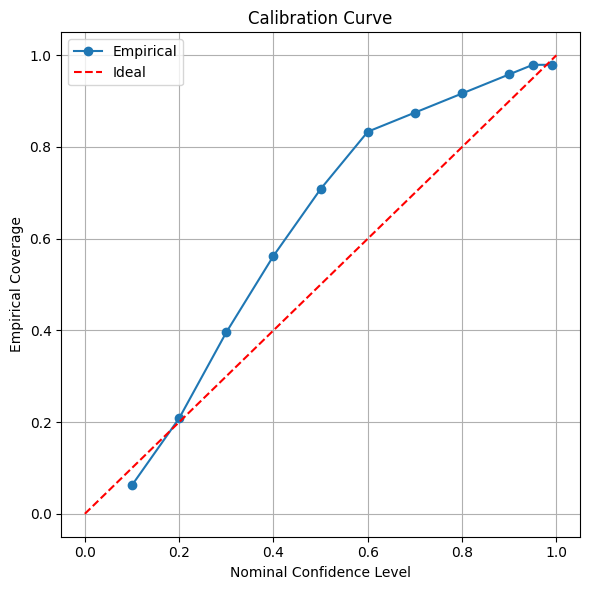


Test Calibration Curve:


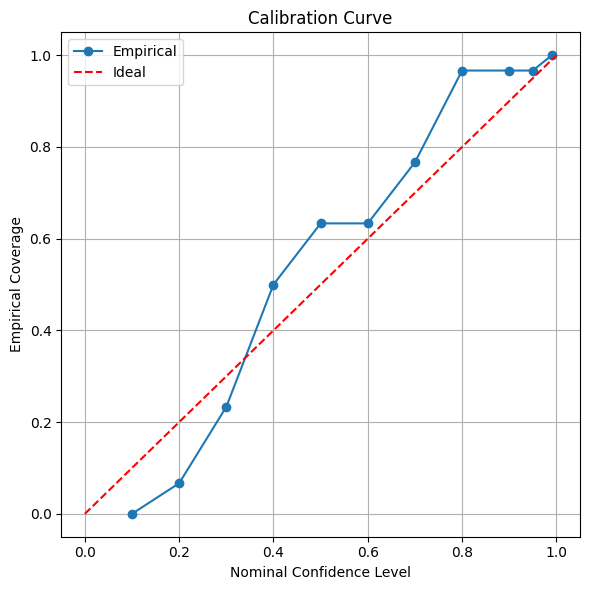

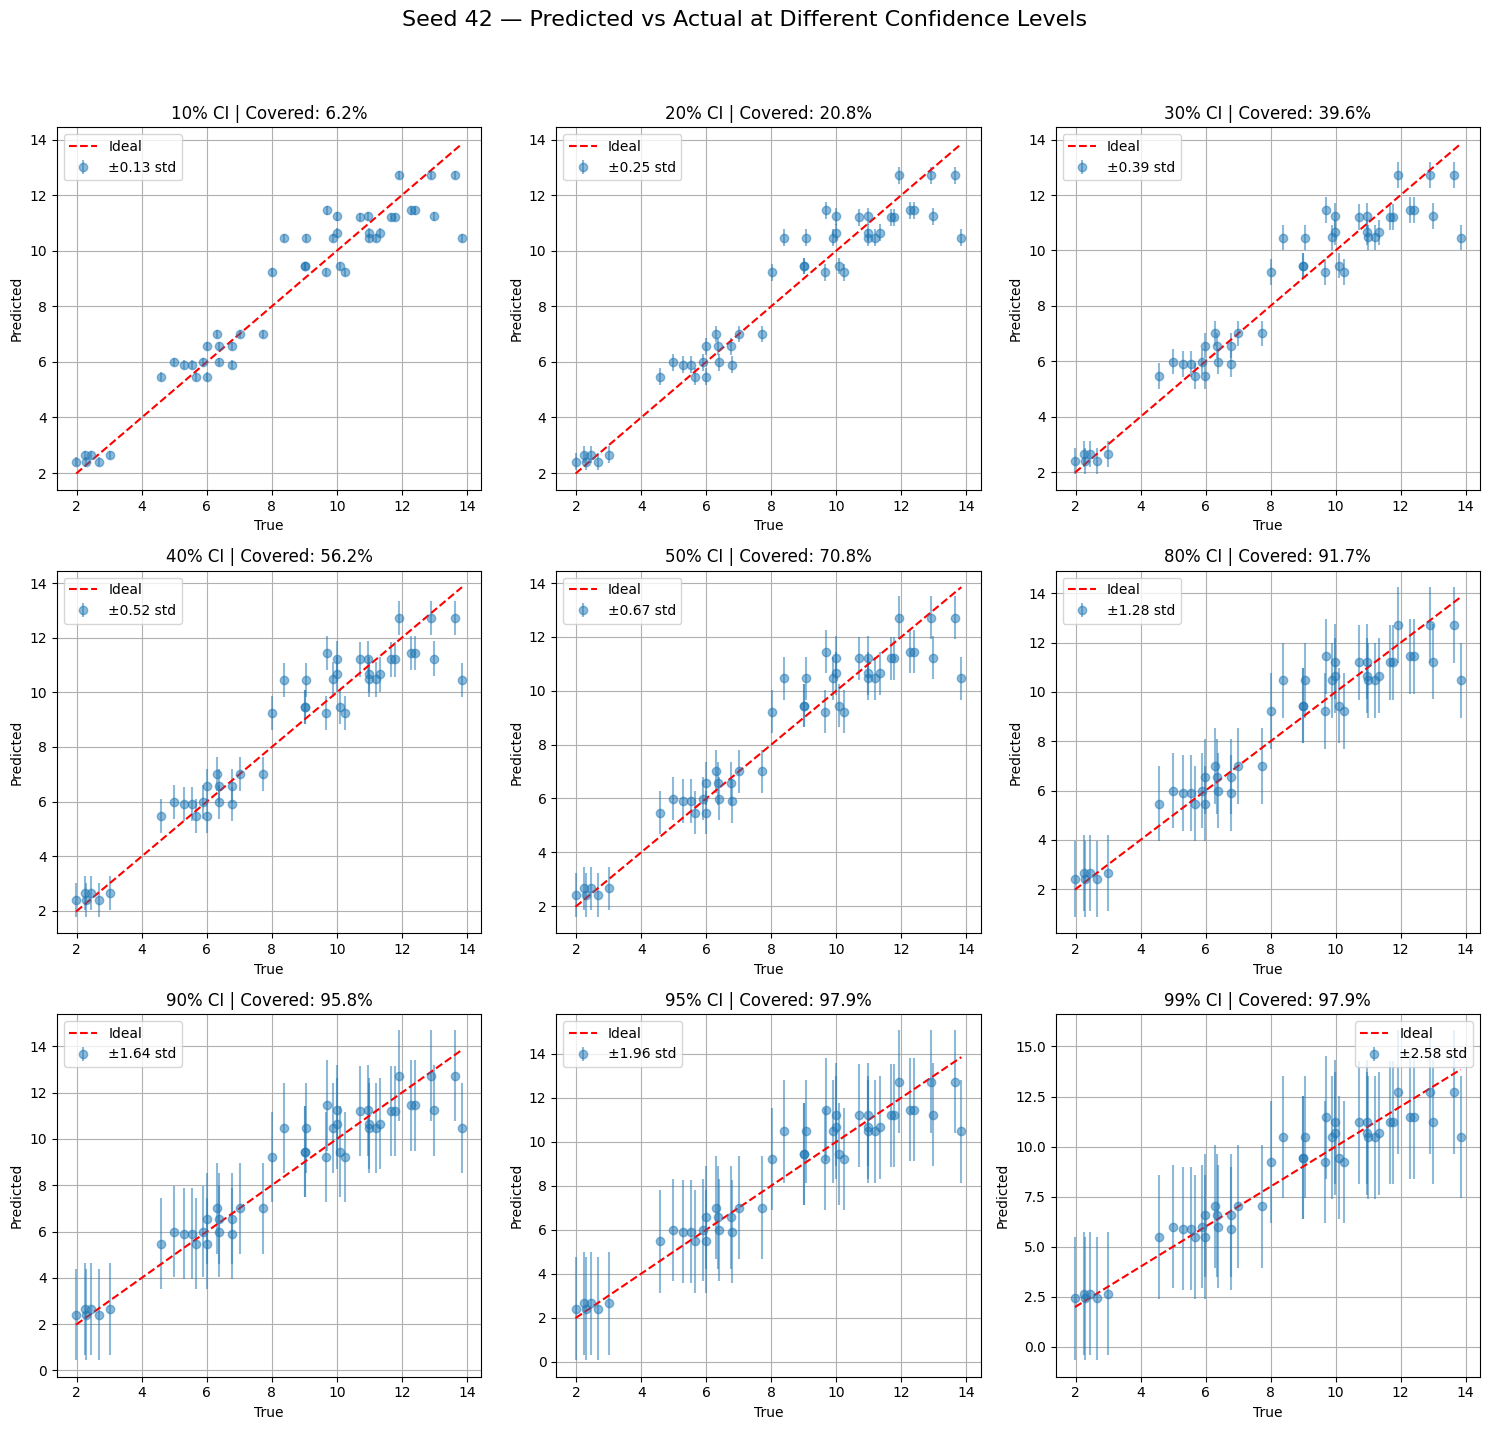

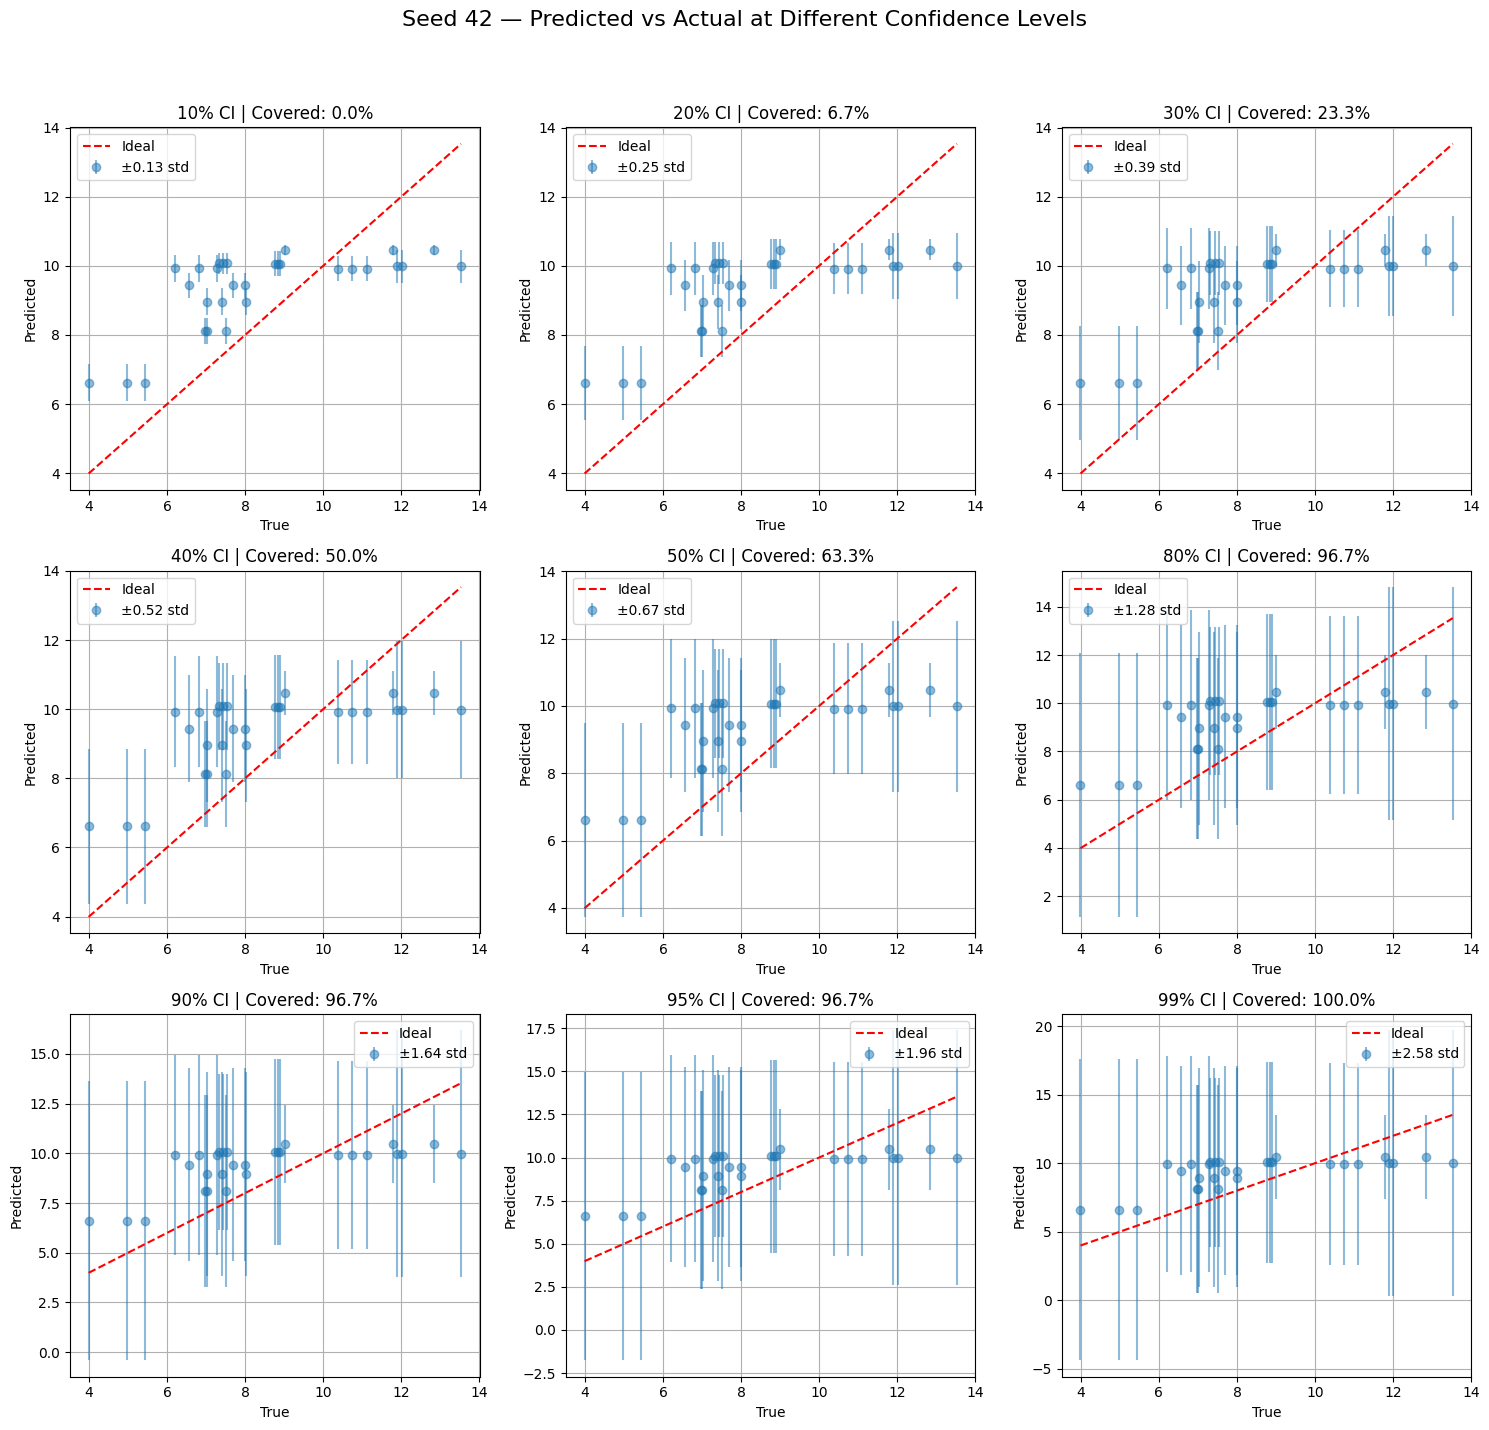

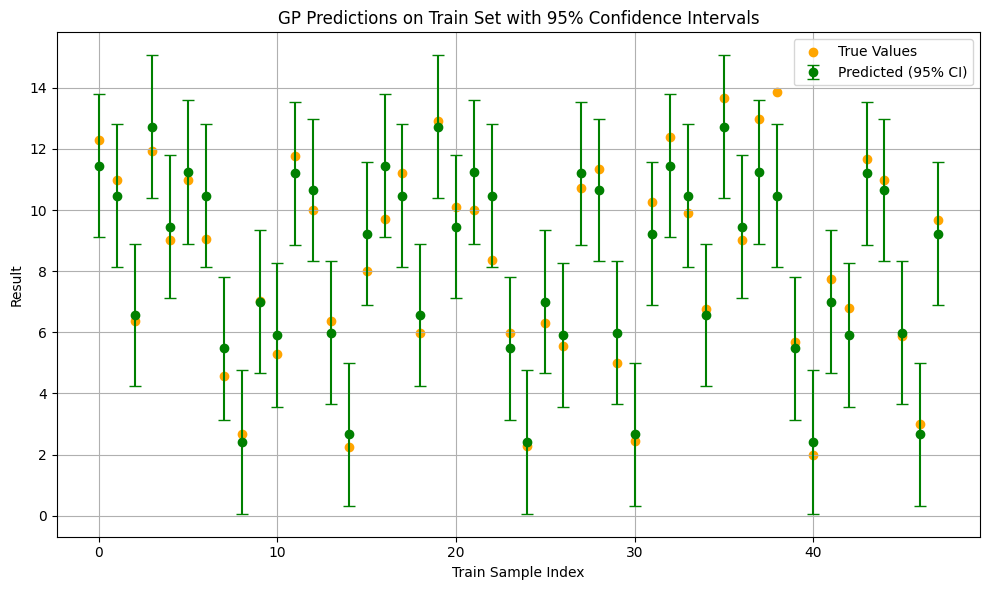

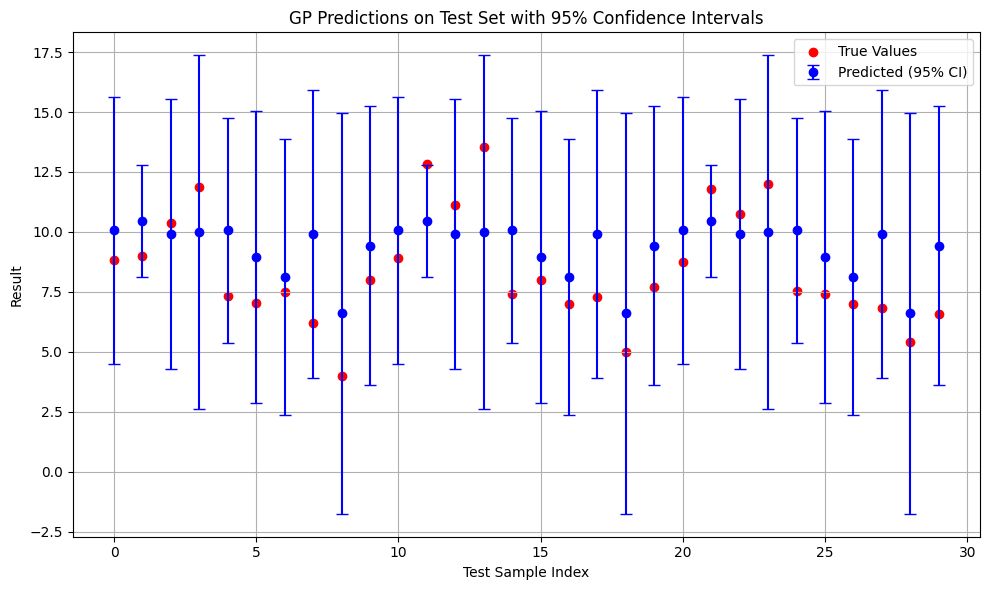

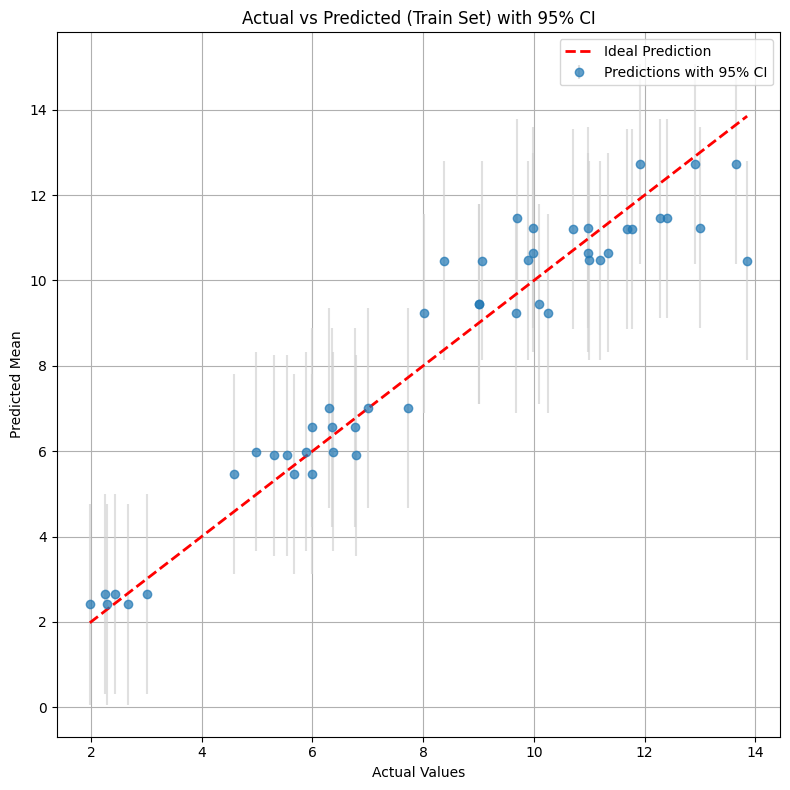

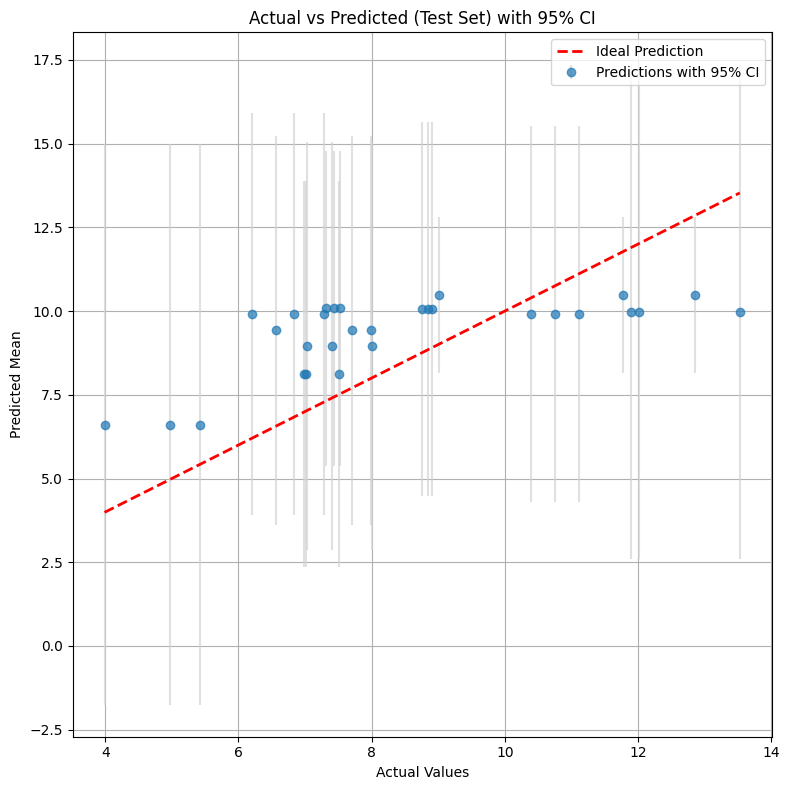

Predictions saved to 'gp_test_predictions.csv'

=== Final Learned Parameters ===
Mean: -0.611342
Kernel Outputscale: 1.718210
Kernel Lengthscale: [1.3262267 1.4619148 1.9640244 2.9651327]
Fixed Likelihood Noise (from trial variance): 0.094589


In [1]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats
import math
import copy
# === Load data ===
df = pd.read_excel('data.xlsx')  # expects columns: a, b, c, d, 1, 2, 3
relevant_columns = ['a', 'b', 'c', 'd']

# === Split BEFORE melting ===
df_train, df_test = train_test_split(df, test_size=0.35, random_state=42)

# === Melt to long format ===
train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

# === Extract inputs and targets ===
X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

# === Standardize inputs and targets ===
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_raw)
X_test = x_scaler.transform(X_test_raw)

y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# === Estimate global noise from training set trial variance ===
train_trial_vars = df_train[[1, 2, 3]].var(axis=1)
estimated_noise_variance = train_trial_vars.mean()
normalized_noise_variance = estimated_noise_variance / (y_scaler.scale_[0]**2)
print(f"Estimated normalized noise variance: {normalized_noise_variance:.6f}")

# === Convert to PyTorch tensors ===
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

# === Define GP Model ===
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        input_dim = train_x.shape[1]
        matern_kernel = gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=input_dim)
        matern_kernel.register_constraint("raw_lengthscale", gpytorch.constraints.Interval(1e-2, 10.0))
        self.covar_module = gpytorch.kernels.ScaleKernel(matern_kernel)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# === Initialize likelihood and model ===
likelihood = gpytorch.likelihoods.GaussianLikelihood()

#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=per_point_noise_tensor)

likelihood.noise = torch.tensor(normalized_noise_variance, dtype=torch.float32)
likelihood.noise_covar.raw_noise.requires_grad = True  # Fix noise

model = ExactGPModel(train_x, train_y, likelihood)

# === Training with Early Stopping ===
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
early_stopping_patience = 15
best_test_loss = float('inf')
epochs_no_improve = 0
best_state_dict = None

# Ensure standardized test labels are available
y_test_std = y_scaler.transform(y_test_raw.reshape(-1,1)).ravel()
test_y_tensor = torch.tensor(y_test_std, dtype=torch.float32)

for i in range(training_iter):
    model.train()
    likelihood.train()
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

    # === Evaluate test loss for early stopping ===
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_output = model(test_x)
        test_loss = -mll(test_output, test_y_tensor).item()

    # === Early stopping logic ===
    if test_loss < best_test_loss - 1e-4:  # small threshold to prevent jitter
        best_test_loss = test_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if i % 10 == 0 or i == training_iter - 1:
        print(f"Iter {i + 1}/{training_iter} - Train Loss: {loss.item():.4f} - Test Loss: {test_loss:.4f}")

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered at iteration {i+1}")
        break

# === Load best model ===
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)


# === Evaluation (Train and Test) ===
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Train set
    train_preds = likelihood(model(train_x))
    train_mean = train_preds.mean.numpy()
    train_lower, train_upper = train_preds.confidence_region()
    train_variance = train_preds.variance.numpy()

    # Test set
    test_preds = likelihood(model(test_x))
    test_mean = test_preds.mean.numpy()
    lower, upper = test_preds.confidence_region()
    test_variance = test_preds.variance.numpy()

# === Un‐scale predictions and compute standard deviations ===
# For train
train_mean_unscaled = y_scaler.inverse_transform(train_mean.reshape(-1,1)).ravel()
train_lower_unscaled = y_scaler.inverse_transform(train_lower.reshape(-1,1)).ravel()
train_upper_unscaled = y_scaler.inverse_transform(train_upper.reshape(-1,1)).ravel()
train_std_unscaled = (train_upper_unscaled - train_lower_unscaled) / (2 * scipy.stats.norm.ppf(0.975))

# For test
test_mean_unscaled = y_scaler.inverse_transform(test_mean.reshape(-1,1)).ravel()
lower_unscaled = y_scaler.inverse_transform(lower.reshape(-1,1)).ravel()
upper_unscaled = y_scaler.inverse_transform(upper.reshape(-1,1)).ravel()
test_std_unscaled = (upper_unscaled - lower_unscaled) / (2 * scipy.stats.norm.ppf(0.975))

y_train_unscaled = y_scaler.inverse_transform(train_y.reshape(-1,1)).ravel()

# === Helper Metric Functions ===
def compute_calibration_error(coverages_dict):
    abs_errors = [abs(nom - emp) for nom, emp in coverages_dict.items()]
    sq_errors = [(nom - emp) ** 2 for nom, emp in coverages_dict.items()]
    return np.mean(abs_errors), np.mean(sq_errors)

def compute_sharpness(std_pred, level=0.9):
    z = scipy.stats.norm.ppf(0.5 + level/2.0)
    return 2 * z * np.mean(std_pred)

def compute_nll(y_true_t, mean_pred_t, logvar_pred_t):
    precision = torch.exp(-logvar_pred_t)
    nll_vals = 0.5 * (logvar_pred_t + (y_true_t - mean_pred_t)**2 * precision)
    return nll_vals.mean().item()

def compute_and_plot_coverage(y_true, y_pred, std_pred, levels=None, plot=True, verbose=True):
    if levels is None:
        levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
    coverages = {}
    for level in levels:
        z = scipy.stats.norm.ppf(0.5 + level/2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred
        coverage = np.mean((y_true >= lower) & (y_true <= upper))
        coverages[round(level,4)] = coverage
        if verbose:
            print(f"{int(level*100)}% CI → Empirical coverage: {coverage*100:.2f}%")
    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(list(coverages.keys()), list(coverages.values()), marker='o', label='Empirical')
        plt.plot([0,1],[0,1],'r--', label='Ideal')
        plt.xlabel("Nominal Confidence Level")
        plt.ylabel("Empirical Coverage")
        plt.title("Calibration Curve")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    return coverages

def plot_seed_coverage_grid(y_true, y_pred, std_pred, coverages_dict, seed, levels=[0.1,0.2,0.3,0.4,0.5,0.8,0.9,0.95,0.99]):
    cols = 3
    rows = math.ceil(len(levels)/cols)
    plt.figure(figsize=(cols * 5, rows * 5))
    for i, level in enumerate(levels):
        z = scipy.stats.norm.ppf(0.5 + level/2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred

        plt.subplot(rows, cols, i+1)
        plt.errorbar(
            y_true,
            y_pred,
            yerr=z * std_pred,
            fmt='o',
            alpha=0.5,
            label=f'±{z:.2f} std'
        )
        plt.plot(
            [y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'r--',
            label='Ideal'
        )
        plt.xlabel("True")
        plt.ylabel("Predicted")
        empirical = coverages_dict.get(round(level,4), None)
        if empirical is not None:
            title = f"{int(level*100)}% CI | Covered: {empirical*100:.1f}%"
        else:
            title = f"{int(level*100)}% CI | Covered: N/A"
        plt.title(title)
        plt.grid(True)
        plt.legend()
    plt.suptitle(f"Seed {seed} — Predicted vs Actual at Different Confidence Levels", fontsize=16)
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

def print_basic_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} Evaluation ===")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    return mae, mse, r2

def full_evaluation(name, y_true, y_pred, std_pred, y_true_std=None, mean_pred_std=None, logvar_pred_std=None):
    # Print basic metrics
    mae, mse, r2 = print_basic_metrics(name, y_true, y_pred)
    # Calibration & sharpness
    coverages = compute_and_plot_coverage(y_true, y_pred, std_pred, plot=False, verbose=False)
    calib_err, msce = compute_calibration_error(coverages)
    sharp90 = compute_sharpness(std_pred, level=0.9)
    print(f"Calibration Error: {calib_err:.4f}")
    print(f"MSCE: {msce:.4f}")
    print(f"Sharpness (90% CI): {sharp90:.4f}")
    # NLL
    if (y_true_std is not None) and (mean_pred_std is not None) and (logvar_pred_std is not None):
        nll = compute_nll(y_true_std, mean_pred_std, logvar_pred_std)
        print(f"NLL: {nll:.4f}")
    else:
        print("NLL: (skipped — logvar or standardized pred missing)")
    return coverages

def plot_actual_vs_predicted(y_true, y_pred, lower, upper, title):
    plt.figure(figsize=(8, 8))
    plt.errorbar(y_true, y_pred,
                 yerr=[y_pred - lower, upper - y_pred],
                 fmt='o', ecolor='lightgray', alpha=0.7, label='Predictions with 95% CI')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Mean')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




# === Compute standardized versions for NLL ===
# For train
train_y_std_t = torch.tensor(y_train, dtype=torch.float32)
train_mean_std_t = torch.tensor(train_mean, dtype=torch.float32)
train_logvar_std_t = torch.tensor(np.log(train_variance + 1e-9), dtype=torch.float32)

# For test
y_test_std = y_scaler.transform(y_test_raw.reshape(-1,1)).ravel()
y_test_std_t = torch.tensor(y_test_std, dtype=torch.float32)
test_mean_std_t = torch.tensor(test_mean, dtype=torch.float32)
test_logvar_std_t = torch.tensor(np.log(test_variance + 1e-9), dtype=torch.float32)

# === Run full evaluations ===
print("\n=== GPR Train Set Evaluation ===")
train_coverages = full_evaluation("Train Set", y_train_unscaled, train_mean_unscaled, train_std_unscaled,
                                  y_true_std=train_y_std_t, mean_pred_std=train_mean_std_t, logvar_pred_std=train_logvar_std_t)

print("\n=== GPR Test Set Evaluation ===")
test_coverages = full_evaluation("Test Set", y_test_raw, test_mean_unscaled, test_std_unscaled,
                                 y_true_std=y_test_std_t, mean_pred_std=test_mean_std_t, logvar_pred_std=test_logvar_std_t)

# === Calibration plots & coverage‐grid plots ===
print("\nTrain Calibration Curve:")
coverages_train = compute_and_plot_coverage(y_train_unscaled, train_mean_unscaled, train_std_unscaled, plot=True, verbose=False)

print("\nTest Calibration Curve:")
coverages_test = compute_and_plot_coverage(y_test_raw, test_mean_unscaled, test_std_unscaled, plot=True, verbose=False)

# Seed coverage grid
seed_val = 42
plot_seed_coverage_grid(y_train_unscaled, train_mean_unscaled, train_std_unscaled, train_coverages, seed=seed_val)
plot_seed_coverage_grid(y_test_raw, test_mean_unscaled, test_std_unscaled, test_coverages, seed=seed_val)

# === Plot train predictions with uncertainty ===
plt.figure(figsize=(10,6))
indices = np.arange(len(y_train_unscaled))
plt.errorbar(indices, train_mean_unscaled,
             yerr=[train_mean_unscaled - train_lower_unscaled, train_upper_unscaled - train_mean_unscaled],
             fmt='o', color='green', capsize=4, label='Predicted (95% CI)')
plt.scatter(indices, y_train_unscaled, color='orange', label='True Values')
plt.title('GP Predictions on Train Set with 95% Confidence Intervals')
plt.xlabel('Train Sample Index')
plt.ylabel('Result')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot test predictions with uncertainty ===
plt.figure(figsize=(10,6))
indices = np.arange(len(y_test_raw))
plt.errorbar(indices, test_mean_unscaled,
             yerr=[test_mean_unscaled - lower_unscaled, upper_unscaled - test_mean_unscaled],
             fmt='o', color='blue', capsize=4, label='Predicted (95% CI)')
plt.scatter(indices, y_test_raw, color='red', label='True Values')
plt.title('GP Predictions on Test Set with 95% Confidence Intervals')
plt.xlabel('Test Sample Index')
plt.ylabel('Result')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Actual vs Predicted plots with intervals
plot_actual_vs_predicted(y_train_unscaled, train_mean_unscaled, train_lower_unscaled, train_upper_unscaled,
                        'Actual vs Predicted (Train Set) with 95% CI')

plot_actual_vs_predicted(y_test_raw, test_mean_unscaled, lower_unscaled, upper_unscaled,
                        'Actual vs Predicted (Test Set) with 95% CI')


# === Save predictions to CSV ===
results_df = pd.DataFrame({
    'a': X_test_raw[:,0],
    'b': X_test_raw[:,1],
    'c': X_test_raw[:,2],
    'd': X_test_raw[:,3],
    'True Result': y_test_raw,
    'Predicted Mean': test_mean_unscaled,
    'Lower CI (95%)': lower_unscaled,
    'Upper CI (95%)': upper_unscaled
})
results_df.to_csv('gp_test_predictions.csv', index=False)
print("Predictions saved to 'gp_test_predictions.csv'")

# === Print final learned parameters ===
print("\n=== Final Learned Parameters ===")
print(f"Mean: {model.mean_module.constant.item():.6f}")
print(f"Kernel Outputscale: {model.covar_module.outputscale.item():.6f}")
print(f"Kernel Lengthscale: {model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().ravel()}")
print(f"Fixed Likelihood Noise (from trial variance): {likelihood.noise.item():.6f}")

In [90]:
coverages_test

{0.1: np.float64(0.0),
 0.2: np.float64(0.0),
 0.3: np.float64(0.2),
 0.4: np.float64(0.4),
 0.5: np.float64(0.5333333333333333),
 0.6: np.float64(0.6),
 0.7: np.float64(0.8),
 0.8: np.float64(0.9333333333333333),
 0.9: np.float64(0.9666666666666667),
 0.95: np.float64(1.0),
 0.99: np.float64(1.0)}

Learned kernel: 1.14**2 * RBF(length_scale=1.14)

=== Train Set Evaluation ===
MAE: 0.5857
MSE: 0.6309
R²: 0.9308
Calibration Error: 0.4847
MSCE: 0.3192
Sharpness (90% CI): 0.1813
NLL: 100.9677


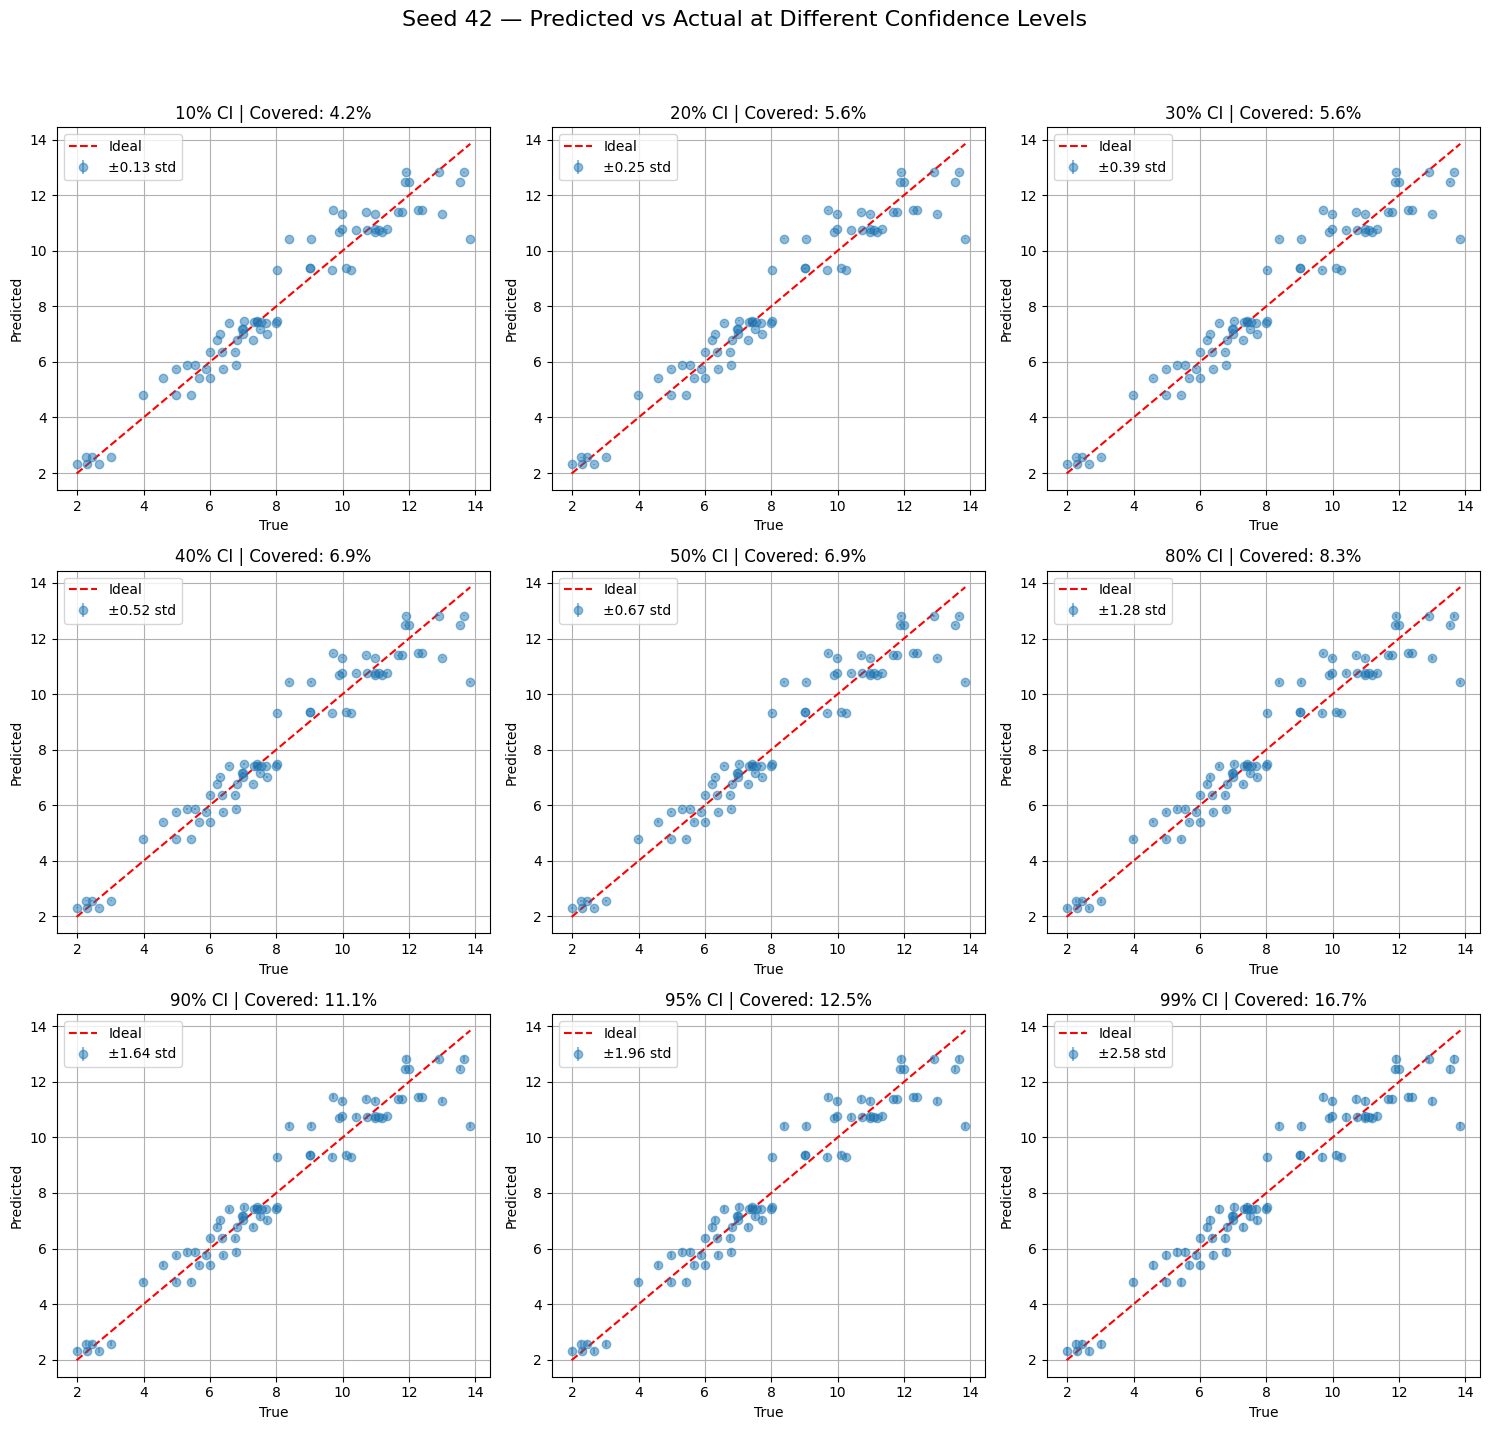


=== Test Set Evaluation ===
MAE: 2.8001
MSE: 9.1064
R²: -2.3444
Calibration Error: 0.5156
MSCE: 0.3492
Sharpness (90% CI): 2.6893
NLL: 266.5426


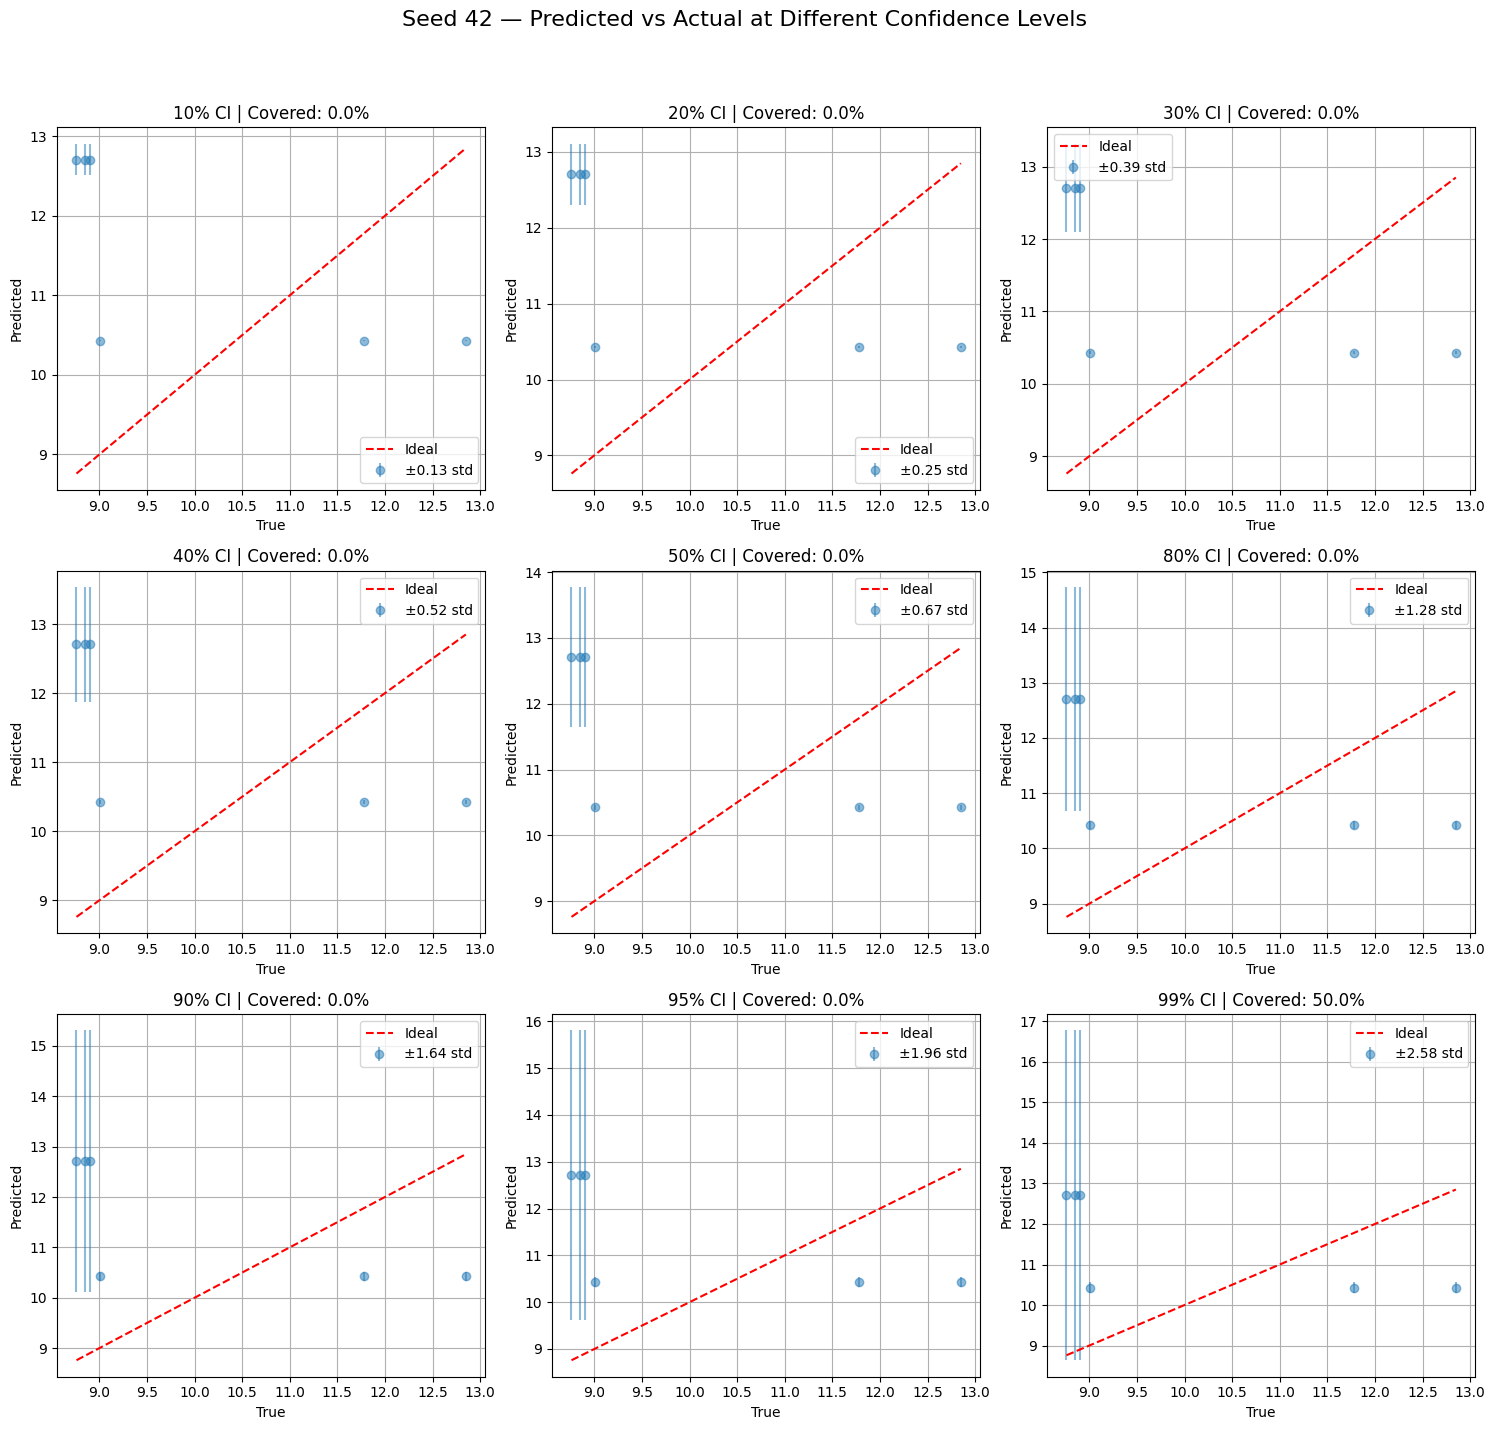

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import torch

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# === Load data ===
df = pd.read_excel('data.xlsx')  # expects columns: a, b, c, d, 1, 2, 3
relevant_columns = ['a', 'b', 'c', 'd']

# === Split BEFORE melting ===
df_train, df_test = train_test_split(df, test_size=0.05, random_state=42)

# === Melt to long format ===
train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

# === Extract inputs and targets ===
X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

# === Scale inputs ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# === Define GPR with RBF kernel and constant kernel multiplier ===
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, alpha=1e-3)

# === Fit model ===
gpr.fit(X_train_scaled, y_train_raw)

print("Learned kernel:", gpr.kernel_)

# === Metric Functions ===

def compute_calibration_error(coverages_dict):
    abs_errors = []
    sq_errors = []
    for nominal, empirical in coverages_dict.items():
        abs_errors.append(abs(nominal - empirical))
        sq_errors.append((nominal - empirical) ** 2)
    mean_abs_calib_error = np.mean(abs_errors)
    msce = np.mean(sq_errors)
    return mean_abs_calib_error, msce

def compute_sharpness(std_pred, level=0.9):
    z = scipy.stats.norm.ppf(0.5 + level / 2.0)
    avg_width = 2 * z * np.mean(std_pred)
    return avg_width

def compute_nll(y_true, mean_pred, logvar_pred):
    precision = torch.exp(-logvar_pred)
    nll = 0.5 * (logvar_pred + (y_true - mean_pred) ** 2 * precision)
    return nll.mean().item()

def compute_empirical_coverages(y_true, y_pred, std_pred, levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9, 0.95, 0.99]):
    coverages = {}
    for level in levels:
        z = scipy.stats.norm.ppf(0.5 + level / 2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred
        covered = (y_true >= lower) & (y_true <= upper)
        empirical_coverage = np.mean(covered)
        coverages[round(level, 4)] = empirical_coverage
    return coverages

def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {label} Set Evaluation ===")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    return mae, mse, r2

def plot_seed_coverage_grid(y_true, y_pred, std_pred, coverages_dict, seed, levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9, 0.95, 0.99]):
    import math
    num_levels = len(levels)
    cols = 3
    rows = math.ceil(num_levels / cols)

    plt.figure(figsize=(cols * 5, rows * 5))

    for i, level in enumerate(levels):
        z = scipy.stats.norm.ppf(0.5 + level / 2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred

        plt.subplot(rows, cols, i + 1)
        plt.errorbar(y_true, y_pred, yerr=z * std_pred, fmt='o', alpha=0.5, label=f'±{z:.2f} std')
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
        plt.xlabel("True")
        plt.ylabel("Predicted")

        empirical = coverages_dict.get(round(level, 4), None)
        if empirical is not None:
            title = f"{int(level*100)}% CI | Covered: {empirical*100:.1f}%"
        else:
            title = f"{int(level*100)}% CI | Covered: N/A"
        plt.title(title)

        plt.grid(True)
        plt.legend()

    plt.suptitle(f"Seed {seed} — Predicted vs Actual at Different Confidence Levels", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# === Evaluation Wrapper ===
def evaluate_gpr_set(X, y_true, label="Set", seed=42):
    # Predict mean and std from GPR
    y_pred, y_std = gpr.predict(X, return_std=True)
    
    # Basic metrics
    mae, mse, r2 = evaluate(y_true, y_pred, label)

    # Calibration
    coverages = compute_empirical_coverages(y_true, y_pred, y_std)
    calib_error, msce = compute_calibration_error(coverages)

    # Sharpness
    sharpness = compute_sharpness(y_std, level=0.9)

    # NLL: logvar = 2 * log(std)
    mean_pred = torch.tensor(y_pred, dtype=torch.float32)
    y_true_tensor = torch.tensor(y_true, dtype=torch.float32)
    logvar_pred = torch.tensor(2 * np.log(y_std), dtype=torch.float32)
    nll = compute_nll(y_true_tensor, mean_pred, logvar_pred)

    # Print extra metrics
    print(f"Calibration Error: {calib_error:.4f}")
    print(f"MSCE: {msce:.4f}")
    print(f"Sharpness (90% CI): {sharpness:.4f}")
    print(f"NLL: {nll:.4f}")

    # Optional: Visualize coverage
    plot_seed_coverage_grid(y_true, y_pred, y_std, coverages_dict=coverages, seed=seed)

    return {
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'Calibration Error': calib_error,
        'MSCE': msce,
        'Sharpness': sharpness,
        'NLL': nll
    }

# === Run Evaluation ===
train_metrics = evaluate_gpr_set(X_train_scaled, y_train_raw, label="Train", seed=42)
test_metrics = evaluate_gpr_set(X_test_scaled, y_test_raw, label="Test", seed=42)

In [38]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Your inputs and targets
# X_train_raw, y_train_raw from your existing code

# Custom MAE scorer (GridSearchCV maximizes score, so use negative MAE)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# === Define new kernels with adjusted bounds ===
kernel_options = [
    # RBF with relaxed lower bound
    C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e2)),

    # RBF with more restrictive lower bound
    C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(0.05, 10.0)),

    # Matern ν=1.5 with standard bounds
    C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(0.01, 100), nu=1.5),

    # Matern ν=2.5 with standard bounds
    C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(0.01, 100), nu=2.5),

    # RBF + WhiteKernel (explicit noise modeling)
    C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1)),
]

# === Parameter grid ===
param_grid = {
    'kernel': kernel_options,
    'alpha': [1e-4, 1e-3, 1e-2],   # Regularization/noise floor
    'normalize_y': [True],
    'n_restarts_optimizer': [5],  # You can increase this to 10+ if time allows
}


# === Set up the grid search ===
gpr_model = GaussianProcessRegressor()
grid_search = GridSearchCV(
    estimator=gpr_model,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=3,  # 3-fold CV
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# === Run the grid search ===
grid_search.fit(X_train_raw, y_train_raw)

# === Results ===
print("\nBest parameters:")
print(grid_search.best_params_)

print(f"\nBest MAE (CV): {-grid_search.best_score_:.4f}")

# === Use best model ===
best_gpr = grid_search.best_estimator_

# Optional: Evaluate on test set
y_pred = best_gpr.predict(X_test_raw)
mae_test = mean_absolute_error(y_test_raw, y_pred)
print(f"\nTest MAE: {mae_test:.4f}")


Fitting 3 folds for each of 15 candidates, totalling 45 fits


/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/khamuham/anaconda


Best parameters:
{'alpha': 0.0001, 'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1), 'n_restarts_optimizer': 5, 'normalize_y': True}

Best MAE (CV): 0.8769

Test MAE: 1.1893


/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [39]:
import pandas as pd
import torch
import gpytorch
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

# Load the Excel file
df = pd.read_excel("data.xlsx")

# Extract inputs (a, b, c, d) and target (average of columns '1', '2', '3')
X = df[['a', 'b', 'c', 'd']].values
y = df[['1', '2', '3']].mean(axis=1).values  # Or use df['Result Average'] if it's accurate

# Normalize inputs and targets
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Convert to PyTorch tensors
train_x = torch.tensor(X_scaled, dtype=torch.float32)
train_y = torch.tensor(y_scaled, dtype=torch.float32)

# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Set up likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
    optimizer.step()

# Switch to evaluation mode
model.eval()
likelihood.eval()

# Predict on training data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

# Inverse-transform predictions
pred_mean = observed_pred.mean.numpy()
pred_mean_unscaled = y_scaler.inverse_transform(pred_mean.reshape(-1, 1)).ravel()

# Compare predicted vs actual
plt.scatter(df['Result Average'], pred_mean_unscaled, alpha=0.7)
plt.xlabel('Actual Result Average')
plt.ylabel('Predicted Result Average')
plt.title('GP Predictions vs Actual')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'gpytorch'

[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1), n_restarts_optimizer=5, normalize_y=True; total time=   0.1s
[CV] END alpha=0.0001, kernel=1**2 * Matern(length_scale=1, nu=1.5), n_restarts_optimizer=5, normalize_y=True; total time=   0.1s
[CV] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1), n_restarts_optimizer=5, normalize_y=True; total time=   0.2s
[CV] END alpha=0.01, kernel=1**2 * Matern(length_scale=1, nu=1.5), n_restarts_optimizer=5, normalize_y=True; total time=   0.1s
[CV] END alpha=0.01, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1), n_restarts_optimizer=5, normalize_y=True; total time=   0.1s
[CV] END alpha=1e-05, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1), n_restarts_optimizer=5, normalize_y=True; total time=   0.4s
[CV] END alpha=0.001, kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1), n_restarts_optimizer=5, normalize_y=True; total time=   0.3s
[CV] END alpha=0.001, kernel=1**2 * 

In [5]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = np.array([1, 2, 3])
y_pred = np.array([1.1, 1.9, 3.2])

rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"RMSE: {rmse}")


TypeError: got an unexpected keyword argument 'squared'